# This a jupyter notebook guide on compartment analysis for chr21

by Pu Zheng and Jun-Han Su

2020.06.06


## Import packages

In [12]:
# imports
import sys, os, glob, time, copy
import numpy as np
import scipy
import pickle

sys.path.append(os.path.abspath(r"..\."))

import source as ia

from scipy.signal import find_peaks
from scipy.spatial.distance import cdist,pdist,squareform

print(os.getpid()) # print this so u can terminate through cmd / task-manager

7096


## Import plotting

In [6]:
# Required plotting setting
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')
_font_size = 7.5

In [11]:
# Required plotting parameters
from source.figure_tools import _dpi,_single_col_width,_double_col_width,_single_row_height,_ref_bar_length, _ticklabel_size,_ticklabel_width,_font_size

In [118]:
# figure folder
parent_figure_folder = r'\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\cleaned_repeat_figure'
#figure_folder = os.path.join(parent_figure_folder, 'Figure2')

figure_folder = r'V:\Chromatin_Share\final_figures\Chr21_compartment_figures'


print(figure_folder)
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)
    print("generating this folder")

V:\Chromatin_Share\final_figures\Chr21_compartment_figures


# 0. Load data

In [13]:
# data folder
data_folder = r'\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\Repicked_chromosome_data'
# load data
data_rep1 = pickle.load(open(os.path.join(data_folder, r'newAnalysis_chr21_after_selection.pkl'),'rb'))
data_rep2 = pickle.load(open(os.path.join(data_folder, r'newAnalysis_chr21-repeat_after_selection.pkl'),'rb'))

## genomic coordinate info

In [14]:
# Load genomic distance maps
# reference folder
ref_folder = r'\\10.245.74.158\Chromatin_NAS_0\References'
# load genomic positions
genomic_dic = ia.get_img_info.Load_Region_Positions(ref_folder)
mid_positions = np.array([_v['midpoint'] for _k,_v in genomic_dic.items()])
mid_positions_Mb = np.round(mid_positions/1e6, 2)

genomic_distance_map = squareform(pdist(mid_positions[:,np.newaxis]))
genomic_distance_entries = genomic_distance_map[np.triu_indices(len(genomic_distance_map),1)]

genomic_positions_Mb = np.round(mid_positions/1e6, 2)
# genomic dist map
genomic_dist_mat = squareform(pdist(genomic_positions_Mb[:,np.newaxis]))

- Importing csv file: \\10.245.74.158\Chromatin_NAS_0\References\Region_Positions.csv
- header: ['region', 'chr', 'start', 'end', 'midpoint']
-- 651 genomic regions loaded!


## 0.1 prepare data domains and compartments

### 0.1.1 domains

In [15]:
sys.path.append(r"\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\BB_forPu")
import DomainAnalysis as da
import multiprocessing as mp

num_threads=32
domain_corr_cutoff = 0.75 
domain_dist_cutoff = 500 # nm

_domain_args = [(_hzxys[:,1:], 4, 1000, domain_corr_cutoff, domain_dist_cutoff) 
                     for _hzxys in data_rep1['dna_hzxys']]
_domain_time = time.time()

print(f"Multiprocessing call domain starts", end=' ')
if 'domain_starts' not in data_rep1:
    with mp.Pool(num_threads) as domain_pool:
        domain_results = domain_pool.starmap(da.get_dom_starts_cor, _domain_args)
        domain_pool.close()
        domain_pool.join()
        domain_pool.terminate()
    # save
    data_rep1['domain_starts'] = [np.array(_r[-1]) for _r in domain_results]
    data_rep1['params']['domain_corr_cutoff'] = domain_corr_cutoff
    data_rep1['params']['domain_dist_cutoff'] = domain_dist_cutoff
    
print(f"in {time.time()-_domain_time:.3f}s.")

Multiprocessing call domain starts in 0.000s.


In [17]:
sys.path.append(r"\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\BB_forPu")
import DomainAnalysis as da
import multiprocessing as mp

num_threads=32
domain_corr_cutoff = 0.75 
domain_dist_cutoff = 500 # nm

_domain_args = [(_hzxys[:,1:], 4, 1000, domain_corr_cutoff, domain_dist_cutoff) 
                     for _hzxys in data_rep2['dna_hzxys']]
_domain_time = time.time()

print(f"Multiprocessing call domain starts", end=' ')
if 'domain_starts' not in data_rep2:
    with mp.Pool(num_threads) as domain_pool:
        domain_results = domain_pool.starmap(da.get_dom_starts_cor, _domain_args)
        domain_pool.close()
        domain_pool.join()
        domain_pool.terminate()
    # save
    data_rep2['domain_starts'] = [np.array(_r[-1]) for _r in domain_results]
    data_rep2['params']['domain_corr_cutoff'] = domain_corr_cutoff
    data_rep2['params']['domain_dist_cutoff'] = domain_dist_cutoff
    
print(f"in {time.time()-_domain_time:.3f}s.")

Multiprocessing call domain starts in 58.317s.


### 0.1.2 compartments

E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


In [86]:
zxys_rep1_list = np.array(data_rep1['dna_hzxys'])[:,:,1:4]
distmap_rep1_list = np.array([squareform(pdist(_zxy)) for _zxy in zxys_rep1_list])

# generate median distance map
median_distance_map_rep1 = np.nanmedian(distmap_rep1_list, axis = 0)
# generate contact map
contact_th = 500
contact_map_rep1 = np.nanmean(distmap_rep1_list < contact_th, axis=0)
# load Hi-C
with np.load(r'\\10.245.74.158\Chromatin_NAS_0\Hi-C\5x10_distmap.npz') as handle:
    hic_raw_map = handle['distance_map']

    
# Generate correlation map
gaussian_sigma = 3

# normalize genomic distance effects
median_entries = median_distance_map_rep1[np.triu_indices(len(median_distance_map_rep1),1)]
kept = (genomic_distance_entries > 0) * (median_entries > 0)
median_lr = scipy.stats.linregress(np.log(genomic_distance_entries[kept]), np.log(median_entries[kept]))
print(median_lr)
median_norm_map = np.exp(np.log(genomic_distance_map) * median_lr.slope + median_lr.intercept)
for _i in range(len(median_norm_map)):
    median_norm_map[_i,_i] = 1
median_normed_map = median_distance_map_rep1 / median_norm_map
# apply gaussian
from scipy.ndimage import gaussian_filter

median_corr_map_rep1 = np.corrcoef(gaussian_filter(median_normed_map, gaussian_sigma))

# normalize genomic distance effects
contact_entries = contact_map_rep1[np.triu_indices(len(contact_map_rep1),1)]
kept = (genomic_distance_entries > 0) * (contact_entries > 0)
contact_lr = scipy.stats.linregress(np.log(genomic_distance_entries[kept]), np.log(contact_entries[kept]))
print(contact_lr)
contact_norm_map = np.exp(np.log(genomic_distance_map) * contact_lr.slope + contact_lr.intercept)
#for _i in range(len(normalization_mat)):
#    contact_norm_map[_i,_i] = 1
contact_normed_map = contact_map_rep1 / contact_norm_map
# apply gaussian
from scipy.ndimage import gaussian_filter

contact_corr_map_rep1 = np.corrcoef(gaussian_filter(contact_normed_map, gaussian_sigma))

# normalize genomic distance effects
hic_entries = hic_raw_map[np.triu_indices(len(hic_raw_map),1)]
kept = (genomic_distance_entries > 0) * (hic_entries > 0)
hic_lr = scipy.stats.linregress(np.log(genomic_distance_entries[kept]), np.log(hic_entries[kept]))
print(hic_lr)
hic_norm_map = np.exp(np.log(genomic_distance_map) * hic_lr.slope + hic_lr.intercept)
#for _i in range(len(normalization_mat)):
#    hic_norm_map[_i,_i] = 1
hic_normed_map = hic_raw_map / hic_norm_map
# apply gaussian
from scipy.ndimage import gaussian_filter

hic_corr_map = np.corrcoef(gaussian_filter(hic_normed_map, gaussian_sigma))

# Do PCA
from sklearn.decomposition import PCA
median_model = PCA(1)
median_model.fit(median_corr_map_rep1)
median_pc1_rep1 = np.reshape(median_model.fit_transform(median_corr_map_rep1), -1)

contact_model = PCA(1)
contact_model.fit(contact_corr_map_rep1)
contact_pc1_rep1 = np.reshape(contact_model.fit_transform(contact_corr_map_rep1), -1)

hic_model = PCA(1)
hic_model.fit(hic_corr_map)
hic_pc1 = np.reshape(hic_model.fit_transform(hic_corr_map), -1)

# get AB reference dictionary
data_rep1['AB_dict'] = {'A':np.where(contact_pc1_rep1 >= 0)[0],
                        'B':np.where(contact_pc1_rep1 < 0)[0],}

LinregressResult(slope=0.2183795133076092, intercept=3.4799716688464644, rvalue=0.8507299788555774, pvalue=0.0, stderr=0.0002933241775438422)


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


LinregressResult(slope=-0.50140253735472, intercept=5.5134138246078415, rvalue=-0.7739569943155706, pvalue=0.0, stderr=0.0008918804744807079)


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


LinregressResult(slope=-0.9585659791626601, intercept=17.080547762418675, rvalue=-0.7693318396343064, pvalue=0.0, stderr=0.0018189995579892685)


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


NameError: name 'median_corr_map' is not defined

In [88]:
zxys_rep2_list = np.array(data_rep2['dna_hzxys'])[:,:,1:4]
distmap_rep2_list = np.array([squareform(pdist(_zxy)) for _zxy in zxys_rep2_list])

# generate median distance map
median_distance_map_rep2 = np.nanmedian(distmap_rep2_list, axis = 0)
# generate contact map
contact_th = 500
contact_map_rep2 = np.nanmean(distmap_rep2_list < contact_th, axis=0)
# load Hi-C
with np.load(r'\\10.245.74.158\Chromatin_NAS_0\Hi-C\5x10_distmap.npz') as handle:
    hic_raw_map = handle['distance_map']

    
# Generate correlation map
gaussian_sigma = 3

# normalize genomic distance effects
median_entries = median_distance_map_rep2[np.triu_indices(len(median_distance_map_rep2),1)]
kept = (genomic_distance_entries > 0) * (median_entries > 0)
median_lr = scipy.stats.linregress(np.log(genomic_distance_entries[kept]), np.log(median_entries[kept]))
print(median_lr)
median_norm_map = np.exp(np.log(genomic_distance_map) * median_lr.slope + median_lr.intercept)
for _i in range(len(median_norm_map)):
    median_norm_map[_i,_i] = 1
median_normed_map = median_distance_map_rep2 / median_norm_map
# apply gaussian
from scipy.ndimage import gaussian_filter

median_corr_map_rep2 = np.corrcoef(gaussian_filter(median_normed_map, gaussian_sigma))

# normalize genomic distance effects
contact_entries = contact_map_rep2[np.triu_indices(len(contact_map_rep2),1)]
kept = (genomic_distance_entries > 0) * (contact_entries > 0)
contact_lr = scipy.stats.linregress(np.log(genomic_distance_entries[kept]), np.log(contact_entries[kept]))
print(contact_lr)
contact_norm_map = np.exp(np.log(genomic_distance_map) * contact_lr.slope + contact_lr.intercept)
#for _i in range(len(normalization_mat)):
#    contact_norm_map[_i,_i] = 1
contact_normed_map = contact_map_rep2 / contact_norm_map
# apply gaussian
from scipy.ndimage import gaussian_filter

contact_corr_map_rep2 = np.corrcoef(gaussian_filter(contact_normed_map, gaussian_sigma))

# normalize genomic distance effects
hic_entries = hic_raw_map[np.triu_indices(len(hic_raw_map),1)]
kept = (genomic_distance_entries > 0) * (hic_entries > 0)
hic_lr = scipy.stats.linregress(np.log(genomic_distance_entries[kept]), np.log(hic_entries[kept]))
print(hic_lr)
hic_norm_map = np.exp(np.log(genomic_distance_map) * hic_lr.slope + hic_lr.intercept)
#for _i in range(len(normalization_mat)):
#    hic_norm_map[_i,_i] = 1
hic_normed_map = hic_raw_map / hic_norm_map
# apply gaussian
from scipy.ndimage import gaussian_filter

hic_corr_map = np.corrcoef(gaussian_filter(hic_normed_map, gaussian_sigma))

# Do PCA
from sklearn.decomposition import PCA
median_model = PCA(1)
median_model.fit(median_corr_map_rep2)
median_pc1_rep2 = np.reshape(median_model.fit_transform(median_corr_map_rep2), -1)

contact_model = PCA(1)
contact_model.fit(contact_corr_map_rep2)
contact_pc1_rep2 = np.reshape(contact_model.fit_transform(contact_corr_map_rep2), -1)

hic_model = PCA(1)
hic_model.fit(hic_corr_map)
hic_pc1 = np.reshape(hic_model.fit_transform(hic_corr_map), -1)

# get AB reference dictionary
data_rep2['AB_dict'] = {'A':np.where(contact_pc1_rep2 >= 0)[0],
                        'B':np.where(contact_pc1_rep2 < 0)[0],}

E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


LinregressResult(slope=0.18713575441979163, intercept=3.977446283688256, rvalue=0.8084691493087969, pvalue=0.0, stderr=0.0002961679908438813)


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


LinregressResult(slope=-0.4147980327437226, intercept=4.288685381360059, rvalue=-0.7179486196355445, pvalue=0.0, stderr=0.000874344135088389)


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


LinregressResult(slope=-0.9585659791626601, intercept=17.080547762418675, rvalue=-0.7693318396343064, pvalue=0.0, stderr=0.0018189995579892685)


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log


# Plots related to compartment calling

## Fig2A: correlation map with AB calling

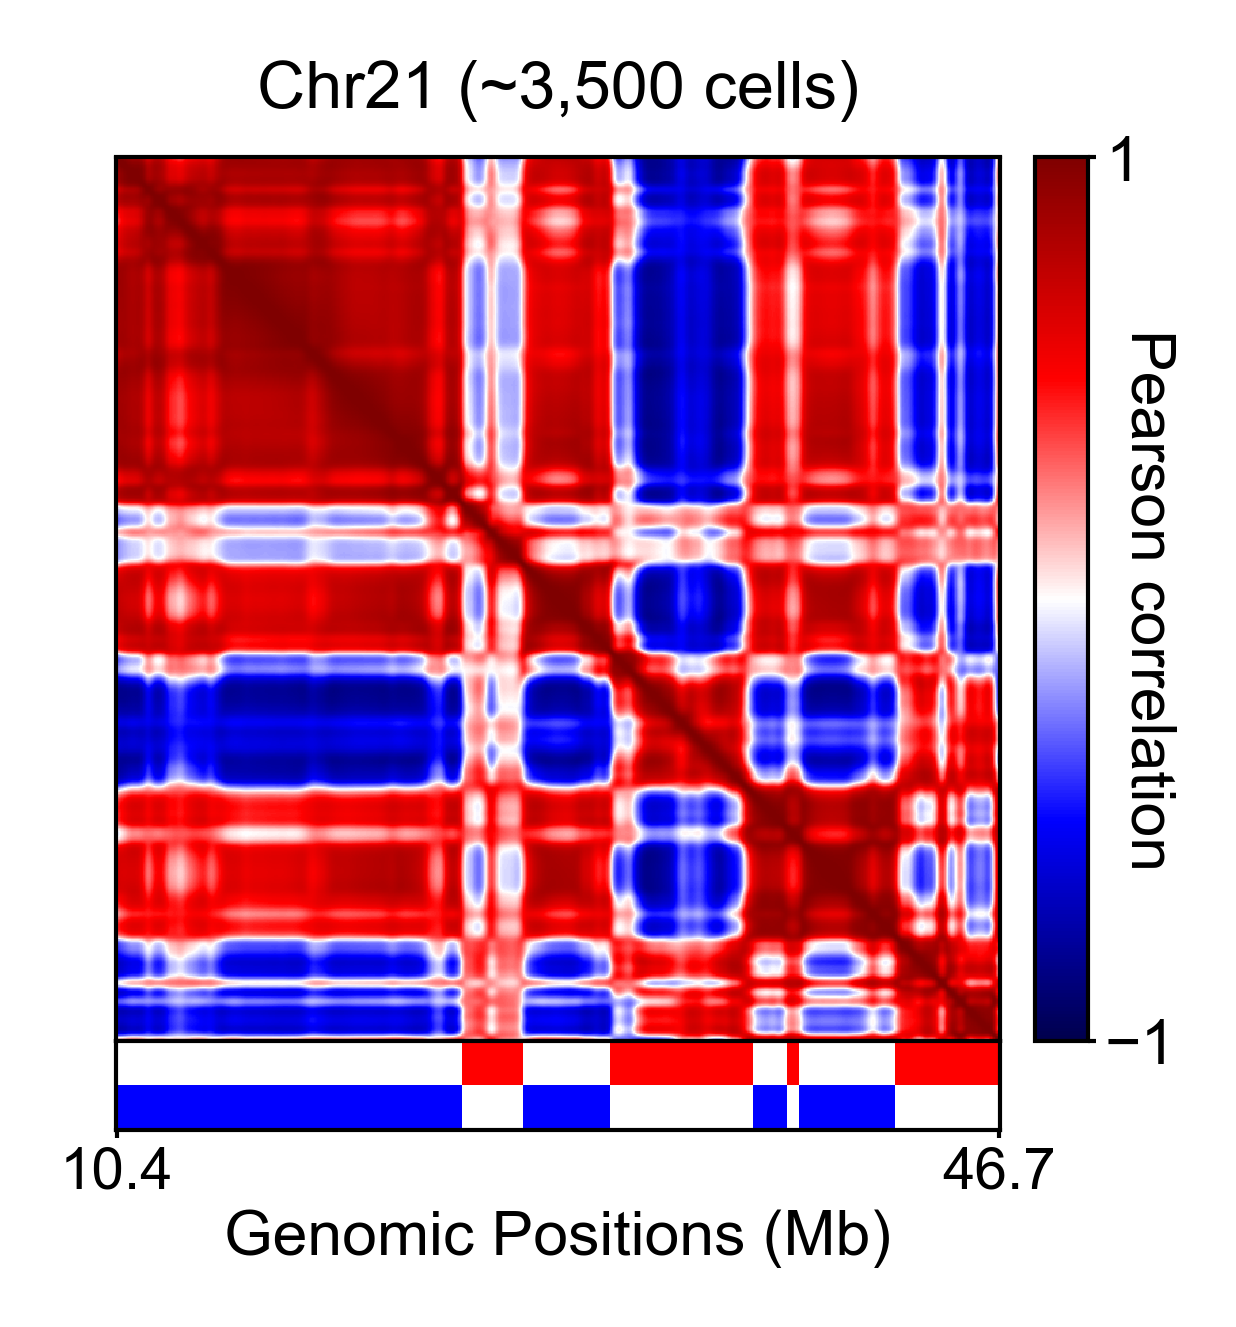

In [101]:
lims = [0,len(contact_corr_map_rep1)]

xlims = np.array([min(lims), max(lims)])
ylims = np.array([min(lims), max(lims)])

from mpl_toolkits.axes_grid1 import make_axes_locatable

domain_line_color = [1,1,0,1]
domain_line_width = 1.5
bad_color=[0,0,0,1]

fig, ax1 = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=600)

# create a color map
current_cmap = matplotlib.cm.get_cmap('seismic')
current_cmap.set_bad(color=[0.5,0.5,0.5,1])

_pf = ax1.imshow(contact_corr_map_rep1, cmap=current_cmap, vmin=-1, vmax=1)

ax1.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=0,
                pad=1, labelleft=False, labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax1.spines.items()]


# locate ax1
divider = make_axes_locatable(ax1)

# colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax1, ticks=[-1,1])
cbar.ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False) # remove bottom ticklabels for ax1
cbar.outline.set_linewidth(_ticklabel_width)
cbar.set_label('Pearson correlation', 
               fontsize=_font_size, labelpad=0, rotation=270)

# create bottom ax
bot_ax = divider.append_axes('bottom', size='10%', pad="0%", 
                             sharex=ax1, xticks=[])
bot_ax.bar(data_rep1['AB_dict']['A'], height=1, color='r', width=1, label='A')
bot_ax.bar(data_rep1['AB_dict']['B'], height=-1, color='b', width=1, label='B')
bot_ax.set_yticks([])
bot_ax.set_yticklabels([])
bot_ax.set_ylim([-1,1])

_xticks = [0, len(contact_corr_map_rep1)-1]
bot_ax.set_xticks(_xticks)
bot_ax.set_xticklabels(np.round(mid_positions_Mb[_xticks],1))
# tick params
bot_ax.tick_params('both', labelsize=_font_size-0.5, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in bot_ax.spines.items()]
# set labels
bot_ax.set_xlabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=1)


# create left ax
#left_ax = divider.append_axes('left', size='10%', pad="0%", sharey=ax1, xticks=[])

#left_ax.barh(data_rep1['AB_dict']['A'], height=1, color='r', width=1, label='A')
#left_ax.barh(data_rep1['AB_dict']['B'], height=1, left=-1, color='b', width=1, label='B')

#left_ax.set_xticks([-0.5, 0.5])
#left_ax.set_xticklabels(['B', 'A'])

#_yticks = _xticks
#left_ax.set_yticks(_yticks)
#left_ax.set_yticklabels(mid_positions_Mb[_yticks])

#left_ax.tick_params('both', labelsize=_font_size-1, 
#                width=_ticklabel_width, length=_ticklabel_size-1,
#                pad=1, labelleft=True) # remove bottom ticklabels for ax1
#[i[1].set_linewidth(_ticklabel_width) for i in left_ax.spines.items()]
#
#left_ax.set_ylabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=1)

# set limits
bot_ax.set_xlim(xlims-0.5)
#left_ax.set_ylim([max(ylims)-0.5, min(ylims)-0.5])

ax1.set_title(f"Chr21 (~3,500 cells)", fontsize=_font_size+0.5)

# save
plt.gcf().subplots_adjust(bottom=0.15, left=0.16, right=0.88)

plt.savefig(os.path.join(figure_folder, f'Fig2A_chr21_contact_corr_map_rep1.pdf'), transparent=True)

plt.show()

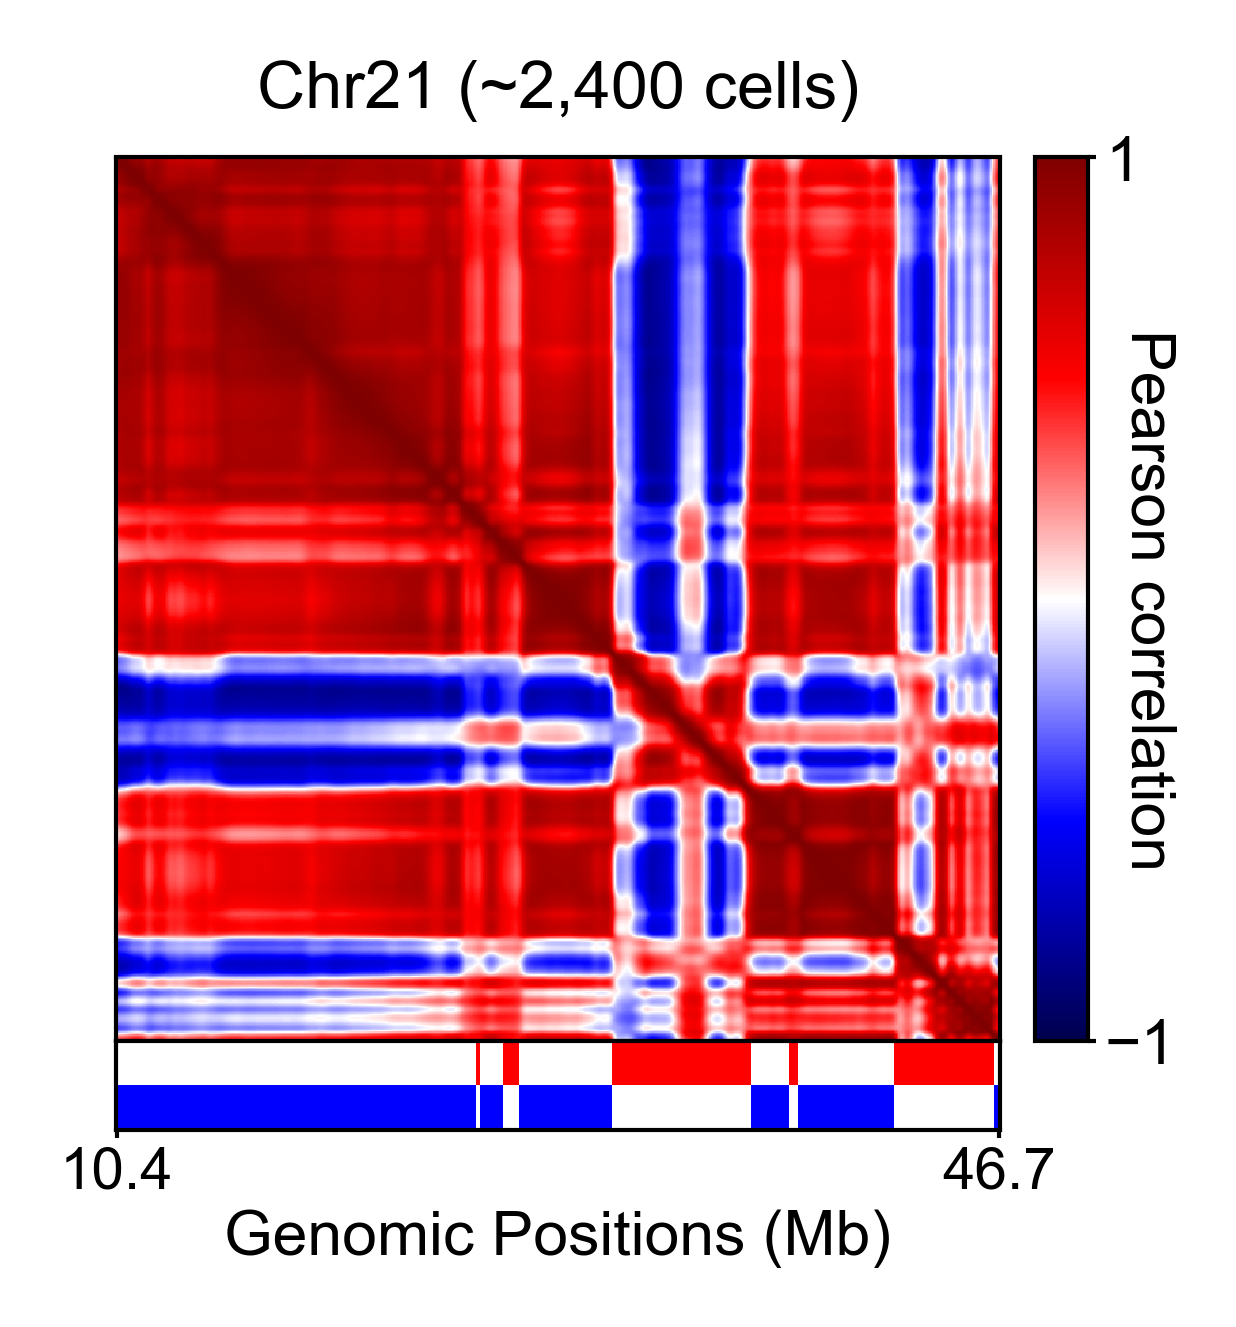

In [115]:
lims = [0,len(contact_corr_map_rep2)]

xlims = np.array([min(lims), max(lims)])
ylims = np.array([min(lims), max(lims)])

from mpl_toolkits.axes_grid1 import make_axes_locatable

domain_line_color = [1,1,0,1]
domain_line_width = 1.5
bad_color=[0,0,0,1]

fig, ax1 = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=600)

# create a color map
current_cmap = matplotlib.cm.get_cmap('seismic')
current_cmap.set_bad(color=[0.5,0.5,0.5,1])

_pf = ax1.imshow(contact_corr_map_rep2, cmap=current_cmap, vmin=-1, vmax=1)

ax1.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=0,
                pad=1, labelleft=False, labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax1.spines.items()]


# locate ax1
divider = make_axes_locatable(ax1)

# colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax1, ticks=[-1,1])
cbar.ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False) # remove bottom ticklabels for ax1
cbar.outline.set_linewidth(_ticklabel_width)
cbar.set_label('Pearson correlation', 
               fontsize=_font_size, labelpad=0, rotation=270)

# create bottom ax
bot_ax = divider.append_axes('bottom', size='10%', pad="0%", 
                             sharex=ax1, xticks=[])
bot_ax.bar(data_rep2['AB_dict']['A'], height=1, color='r', width=1, label='A')
bot_ax.bar(data_rep2['AB_dict']['B'], height=-1, color='b', width=1, label='B')
bot_ax.set_yticks([])
bot_ax.set_yticklabels([])
bot_ax.set_ylim([-1,1])

_xticks = [0, len(contact_corr_map_rep2)-1]
bot_ax.set_xticks(_xticks)
bot_ax.set_xticklabels(np.round(mid_positions_Mb[_xticks],1))
# tick params
bot_ax.tick_params('both', labelsize=_font_size-0.5, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in bot_ax.spines.items()]
# set labels
bot_ax.set_xlabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=1)


# create left ax
#left_ax = divider.append_axes('left', size='10%', pad="0%", sharey=ax1, xticks=[])

#left_ax.barh(data_rep2['AB_dict']['A'], height=1, color='r', width=1, label='A')
#left_ax.barh(data_rep2['AB_dict']['B'], height=1, left=-1, color='b', width=1, label='B')

#left_ax.set_xticks([-0.5, 0.5])
#left_ax.set_xticklabels(['B', 'A'])

#_yticks = _xticks
#left_ax.set_yticks(_yticks)
#left_ax.set_yticklabels(mid_positions_Mb[_yticks])

#left_ax.tick_params('both', labelsize=_font_size-1, 
#                width=_ticklabel_width, length=_ticklabel_size-1,
#                pad=1, labelleft=True) # remove bottom ticklabels for ax1
#[i[1].set_linewidth(_ticklabel_width) for i in left_ax.spines.items()]
#
#left_ax.set_ylabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=1)

# set limits
bot_ax.set_xlim(xlims-0.5)
#left_ax.set_ylim([max(ylims)-0.5, min(ylims)-0.5])

ax1.set_title(f"Chr21 (~2,400 cells)", fontsize=_font_size+0.5)

# save
plt.gcf().subplots_adjust(bottom=0.15, left=0.16, right=0.88)

plt.savefig(os.path.join(figure_folder, f'Fig2A_chr21_contact_corr_map_rep2.pdf'), transparent=True)

plt.show()

## FigS2A: plot PC1 for chr21 calling

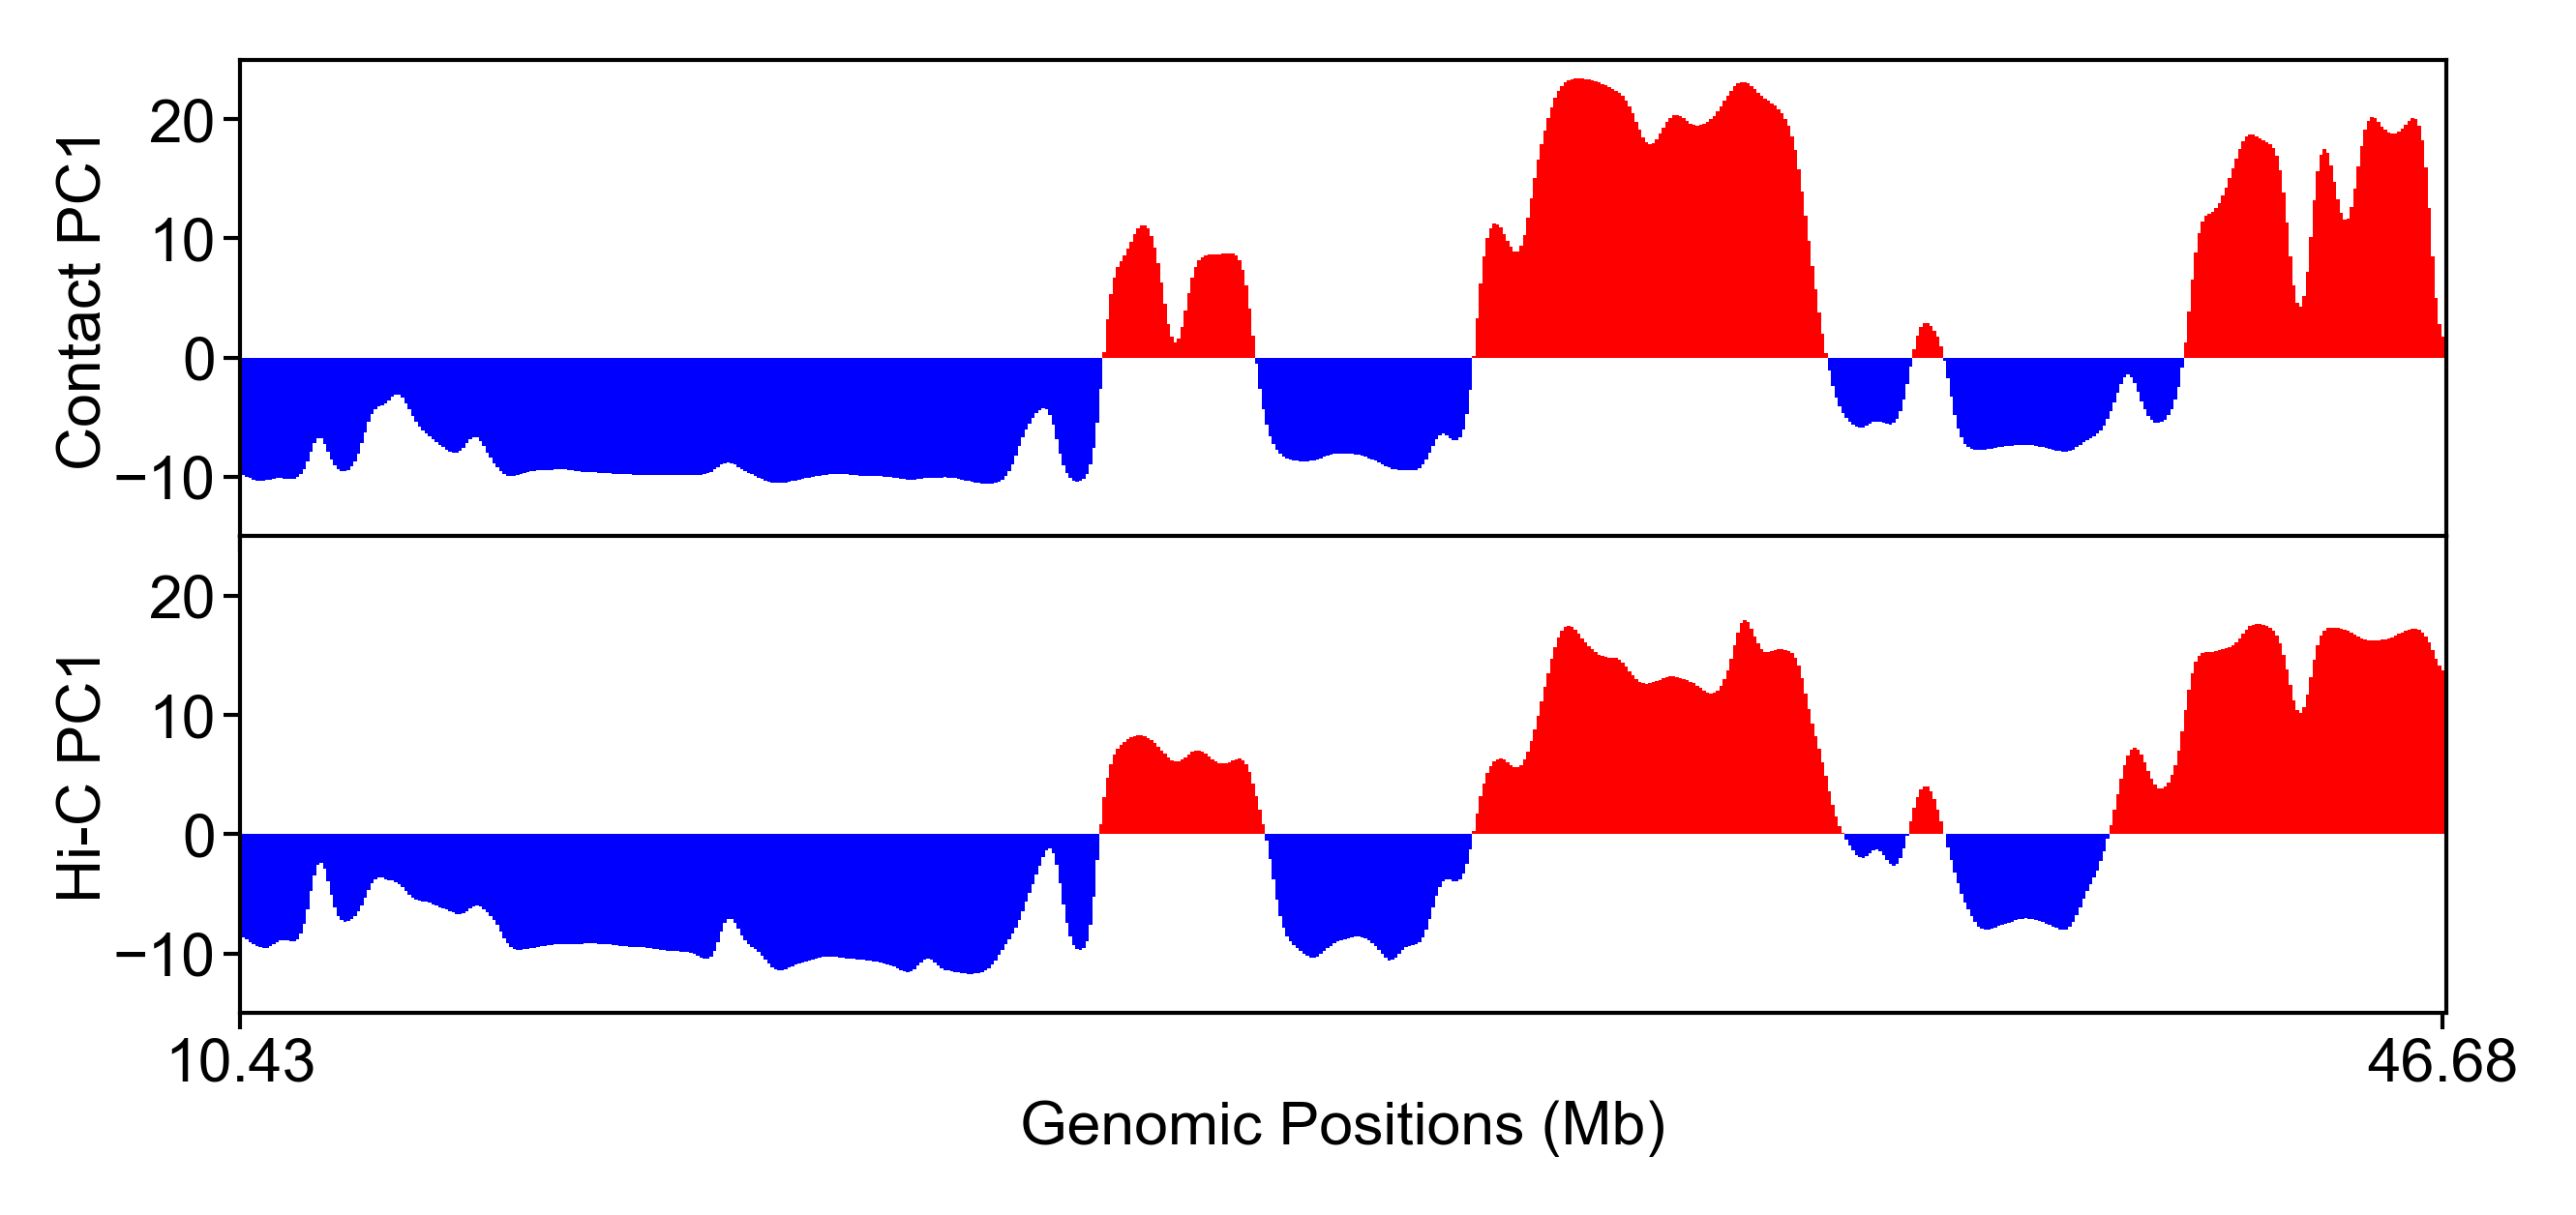

In [104]:
## pc1 barplot
fig, ax = plt.subplots(figsize=(_double_col_width, _single_col_width), dpi=600)
grid = plt.GridSpec(2, 1, height_ratios=[1,1], hspace=0., wspace=0.)
contact_ax = plt.subplot(grid[0])
contact_ax.bar(np.where(contact_pc1_rep1>=0)[0],
               contact_pc1_rep1[contact_pc1_rep1>=0],
               width=1, color='r', label='A')
contact_ax.bar(np.where(contact_pc1_rep1<0)[0],
               contact_pc1_rep1[contact_pc1_rep1<0],
               width=1, color='b', label='B')
contact_ax.tick_params('both', labelsize=_font_size, 
            width=_ticklabel_width, length=_ticklabel_size,
            pad=1,labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in contact_ax.spines.items()]
contact_ax.set_ylim([-15,25])
contact_ax.set_yticks([-10,0,10,20])
contact_ax.set_ylabel("Contact PC1", fontsize=_font_size, labelpad=0)


# hic-ax
hic_ax = plt.subplot(grid[1], sharex=contact_ax)

hic_ax.bar(np.where(hic_pc1>=0)[0],
               hic_pc1[hic_pc1>=0],
               width=1, color='r', label='A')
hic_ax.bar(np.where(hic_pc1<0)[0],
               hic_pc1[hic_pc1<0],
               width=1, color='b', label='B')
hic_ax.tick_params('both', labelsize=_font_size, 
            width=_ticklabel_width, length=_ticklabel_size,
            pad=1,) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in hic_ax.spines.items()]
hic_ax.set_ylim([-15,25])
hic_ax.set_yticks([-10,0,10,20])
hic_ax.set_ylabel("Hi-C PC1", fontsize=_font_size, labelpad=0)

# set x
hic_ax.set_xlim([0, len(contact_pc1_rep1)])
_xticks = [0, len(contact_pc1_rep1)-1]
hic_ax.set_xticks(_xticks)
hic_ax.set_xticklabels(mid_positions_Mb[_xticks])
hic_ax.set_xlabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.1)

plt.savefig(os.path.join(figure_folder, f'FigS2A_chr21_PC1_barplot_rep1.pdf'), transparent=True)

plt.show()

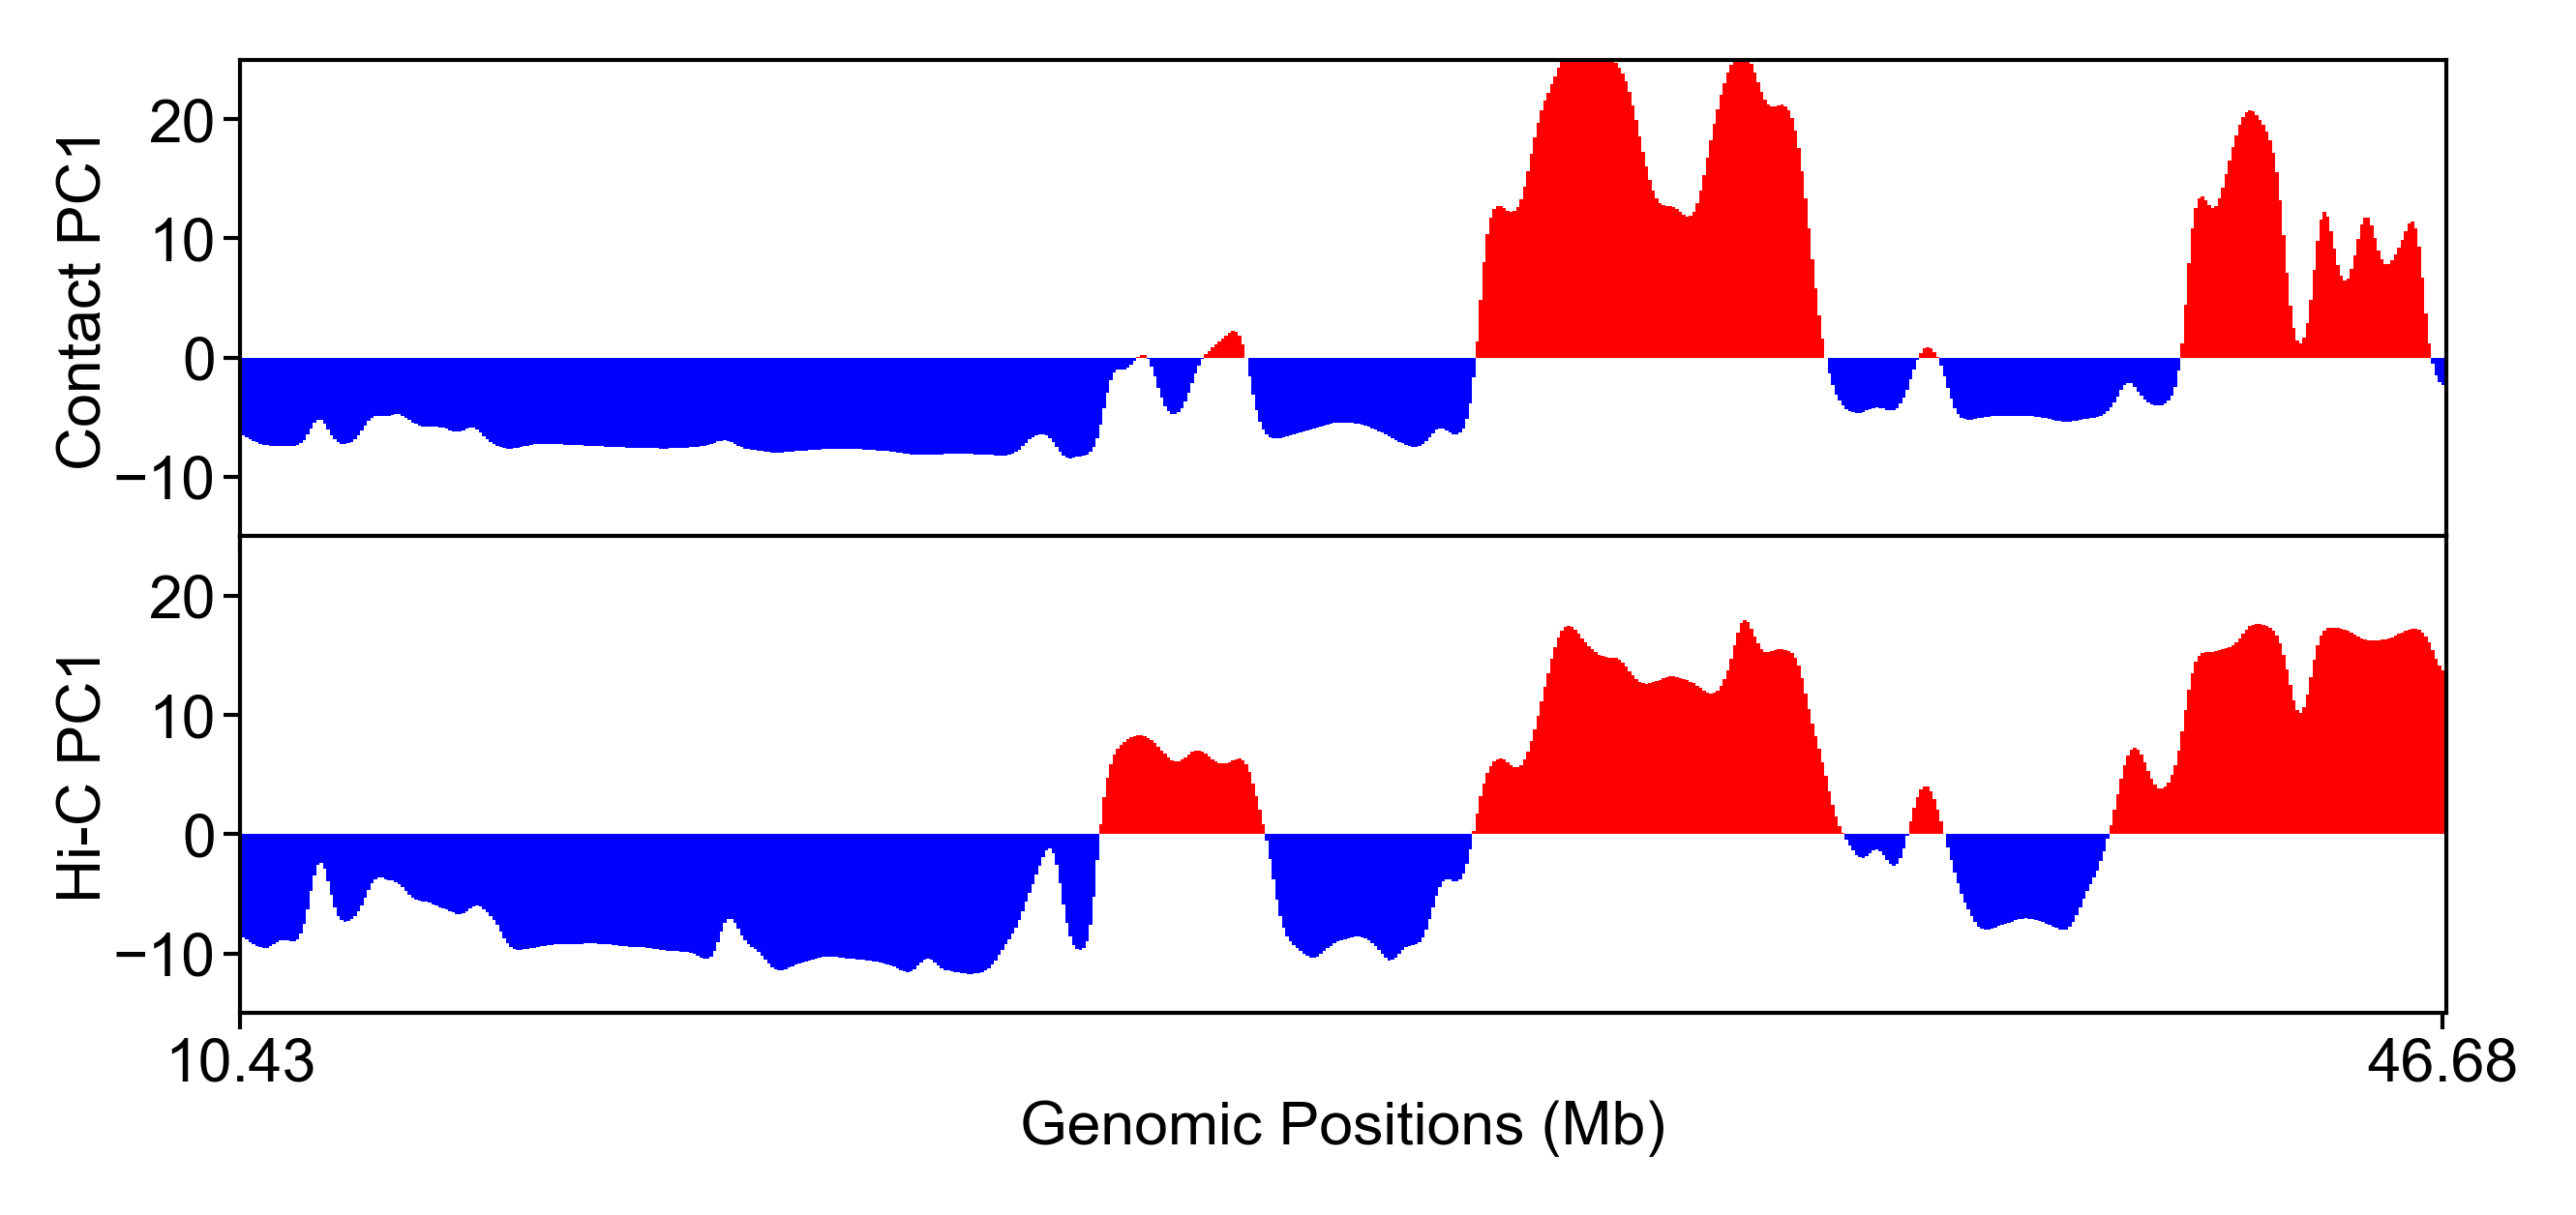

In [105]:
## pc1 barplot
fig, ax = plt.subplots(figsize=(_double_col_width, _single_col_width), dpi=600)
grid = plt.GridSpec(2, 1, height_ratios=[1,1], hspace=0., wspace=0.)
contact_ax = plt.subplot(grid[0])
contact_ax.bar(np.where(contact_pc1_rep2>=0)[0],
               contact_pc1_rep2[contact_pc1_rep2>=0],
               width=1, color='r', label='A')
contact_ax.bar(np.where(contact_pc1_rep2<0)[0],
               contact_pc1_rep2[contact_pc1_rep2<0],
               width=1, color='b', label='B')
contact_ax.tick_params('both', labelsize=_font_size, 
            width=_ticklabel_width, length=_ticklabel_size,
            pad=1,labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in contact_ax.spines.items()]
contact_ax.set_ylim([-15,25])
contact_ax.set_yticks([-10,0,10,20])
contact_ax.set_ylabel("Contact PC1", fontsize=_font_size, labelpad=0)


# hic-ax
hic_ax = plt.subplot(grid[1], sharex=contact_ax)

hic_ax.bar(np.where(hic_pc1>=0)[0],
               hic_pc1[hic_pc1>=0],
               width=1, color='r', label='A')
hic_ax.bar(np.where(hic_pc1<0)[0],
               hic_pc1[hic_pc1<0],
               width=1, color='b', label='B')
hic_ax.tick_params('both', labelsize=_font_size, 
            width=_ticklabel_width, length=_ticklabel_size,
            pad=1,) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in hic_ax.spines.items()]
hic_ax.set_ylim([-15,25])
hic_ax.set_yticks([-10,0,10,20])
hic_ax.set_ylabel("Hi-C PC1", fontsize=_font_size, labelpad=0)

# set x
hic_ax.set_xlim([0, len(contact_pc1_rep2)])
_xticks = [0, len(contact_pc1_rep2)-1]
hic_ax.set_xticks(_xticks)
hic_ax.set_xticklabels(mid_positions_Mb[_xticks])
hic_ax.set_xlabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.1)

plt.savefig(os.path.join(figure_folder, f'FigS2A_chr21_PC1_barplot_rep2.pdf'), transparent=True)

plt.show()

### 0.1.3 density scores

In [23]:
del(data_rep1['dna_density_scores'])
del(data_rep1['gene_density_scores'])

In [24]:
import multiprocessing as mp
num_threads=32
density_var = 108 # nm

# density score for 50kb genomic regions
_dna_density_args = [(_hzxys,_hzxys, data_rep1['AB_dict'], [density_var,density_var,density_var], True) 
                     for _hzxys in data_rep1['dna_hzxys']]
_dna_density_time = time.time()

print(f"Multiprocessing calculate dna_density_scores", end=' ')
if 'dna_density_scores' not in data_rep1:
    with mp.Pool(num_threads) as dna_density_pool:
        dna_density_dicts = dna_density_pool.starmap(ia.compartment_tools.scoring.spot_density_scores, _dna_density_args)
        dna_density_pool.close()
        dna_density_pool.join()
        dna_density_pool.terminate()
    # save
    data_rep1['dna_density_scores'] = dna_density_dicts
print(f"in {time.time()-_dna_density_time:.3f}s.")

# density score for tss
_gene_density_args = [(_ghzxys,_hzxys, data_rep1['AB_dict'], [density_var,density_var,density_var], True) 
                     for _ghzxys, _hzxys in zip(data_rep1['gene_hzxys'], data_rep1['dna_hzxys']) ]
_gene_density_time = time.time()

print(f"Multiprocessing calculate gene_density_scores", end=' ')
if 'gene_density_scores' not in data_rep1:
    with mp.Pool(num_threads) as gene_density_pool:
        gene_density_dicts = gene_density_pool.starmap(ia.compartment_tools.scoring.spot_density_scores, _gene_density_args)
        gene_density_pool.close()
        gene_density_pool.join()
        gene_density_pool.terminate()
    # save
    data_rep1['gene_density_scores'] = gene_density_dicts
print(f"in {time.time()-_gene_density_time:.3f}s.")

Multiprocessing calculate dna_density_scores in 49.954s.


In [27]:
del(data_rep2['dna_density_scores'])
del(data_rep2['gene_density_scores'])

In [28]:
import multiprocessing as mp
num_threads=32
density_var = 108 # nm

# density score for 50kb genomic regions
_dna_density_args = [(_hzxys,_hzxys, data_rep2['AB_dict'], [density_var,density_var,density_var], True) 
                     for _hzxys in data_rep2['dna_hzxys']]
_dna_density_time = time.time()

print(f"Multiprocessing calculate dna_density_scores", end=' ')
if 'dna_density_scores' not in data_rep2:
    with mp.Pool(num_threads) as dna_density_pool:
        dna_density_dicts = dna_density_pool.starmap(ia.compartment_tools.scoring.spot_density_scores, _dna_density_args)
        dna_density_pool.close()
        dna_density_pool.join()
        dna_density_pool.terminate()
    # save
    data_rep2['dna_density_scores'] = dna_density_dicts
print(f"in {time.time()-_dna_density_time:.3f}s.")

# density score for tss
_gene_density_args = [(_ghzxys,_hzxys, data_rep2['AB_dict'], [density_var,density_var,density_var], True) 
                     for _ghzxys, _hzxys in zip(data_rep2['gene_hzxys'], data_rep2['dna_hzxys']) ]
_gene_density_time = time.time()

print(f"Multiprocessing calculate gene_density_scores", end=' ')
if 'gene_density_scores' not in data_rep2:
    with mp.Pool(num_threads) as gene_density_pool:
        gene_density_dicts = gene_density_pool.starmap(ia.compartment_tools.scoring.spot_density_scores, _gene_density_args)
        gene_density_pool.close()
        gene_density_pool.join()
        gene_density_pool.terminate()
    # save
    data_rep2['gene_density_scores'] = gene_density_dicts
print(f"in {time.time()-_gene_density_time:.3f}s.")

Multiprocessing calculate dna_density_scores in 26.880s.
Multiprocessing calculate gene_density_scores in 9.949s.


## FigS2C: mean density for chr21

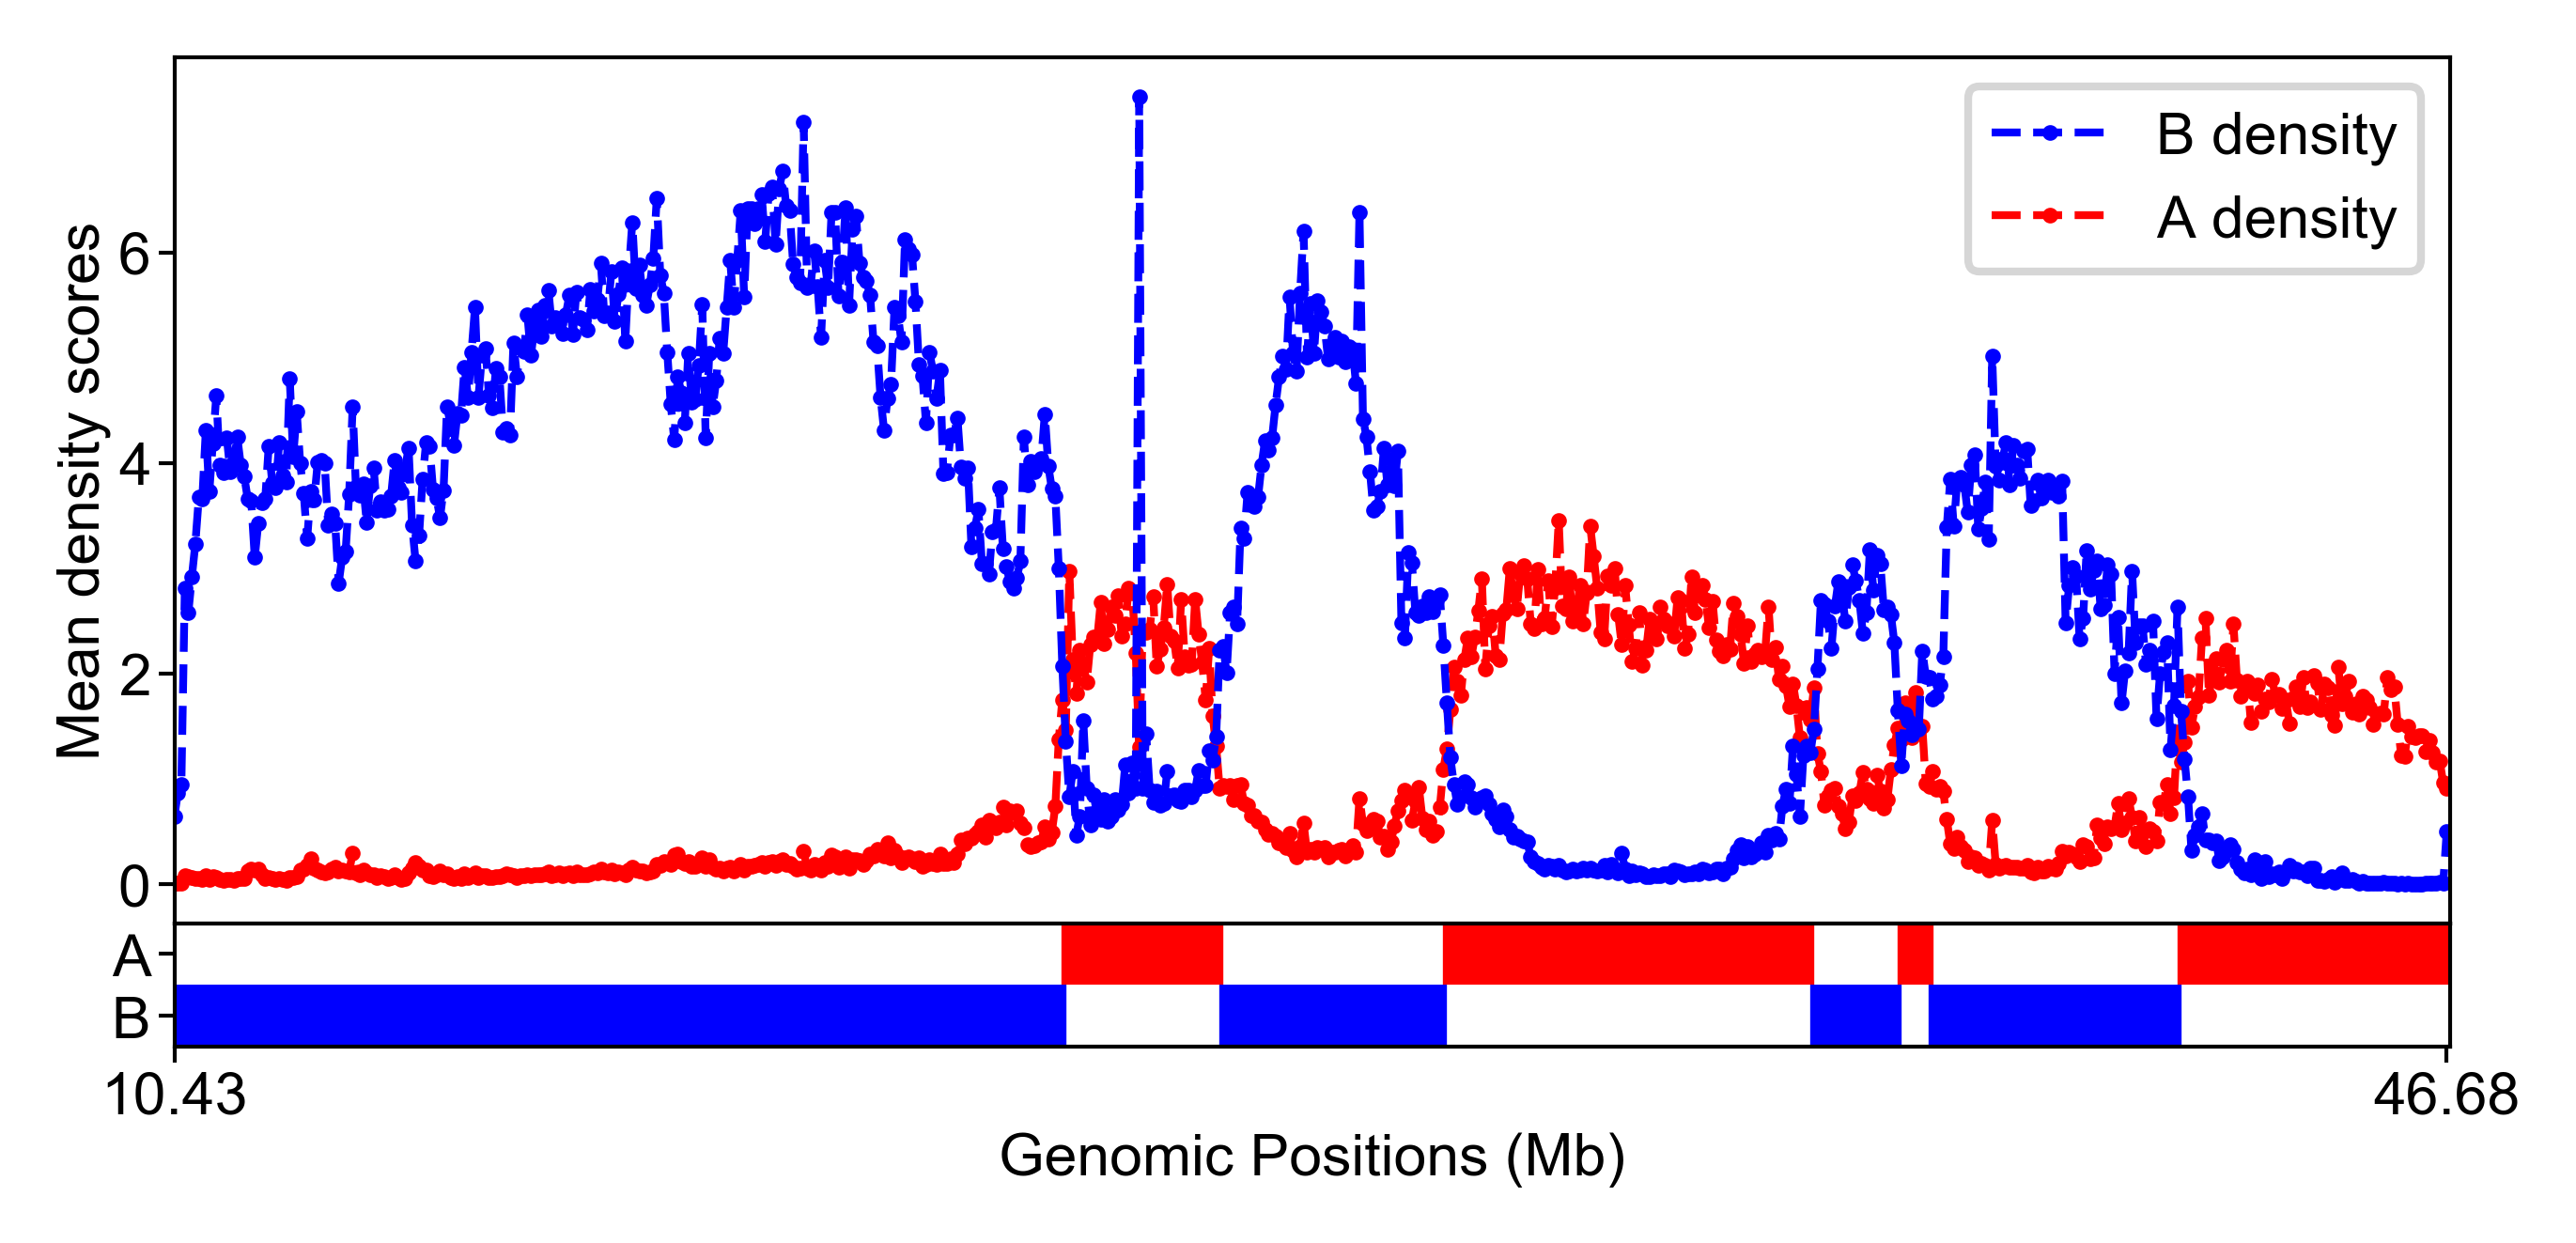

In [113]:
# Calculate mean A, B density
mean_A_scores = np.nanmedian([_s['A'] for _s in data_rep1['dna_density_scores']], axis=0)
mean_B_scores = np.nanmedian([_s['B'] for _s in data_rep1['dna_density_scores']], axis=0)

# Plot
fig = plt.figure(figsize=(_double_col_width, _single_col_width),dpi=600)
grid = plt.GridSpec(2, 1, height_ratios=[7,1], hspace=0., wspace=0.2)

main_ax = plt.subplot(grid[0], xticklabels=[])

main_ax.plot(mean_A_scores, 'r.--', label='A density', markersize=2, linewidth=1)
main_ax.plot(mean_B_scores, 'b.--', label='B density', markersize=2, linewidth=1)

# ticks
main_ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelbottom=False) # remove bottom ticklabels for ax1
main_ax.tick_params('x', length=0)
[i[1].set_linewidth(_ticklabel_width) for i in main_ax.spines.items()]
main_ax.set_ylabel(f"Mean density scores", fontsize=_font_size, labelpad=1)

handles, labels = main_ax.get_legend_handles_labels()
main_ax.legend(handles[::-1], labels[::-1], fontsize=_font_size, loc='upper right')
main_ax.set_xlim(0,len(mean_A_scores))

comp_ax = plt.subplot(grid[1], xticklabels=[], sharex=main_ax)
comp_ax.eventplot([data_rep1['AB_dict']['A'], data_rep1['AB_dict']['B']], lineoffsets=[0.5,-0.5],linelengths=1, linewidths=1, 
                   colors=np.array([[1, 0, 0],[0, 0, 1]]))
#comp_ax.imshow(comp_vector[np.newaxis,:], cmap='seismic', vmin=-1, vmax=1)
comp_ax.tick_params('both', labelsize=_font_size, 
                    width=_ticklabel_width, length=_ticklabel_size,
                    pad=1, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in comp_ax.spines.items()]

comp_ax.set_yticks([0.5,-0.5])
comp_ax.set_yticklabels(["A","B"])
comp_ax.set_ylim([-1,1])
_xticks = [0, len(mean_A_scores)-1]
comp_ax.set_xticks(_xticks)
comp_ax.set_xticklabels(mid_positions_Mb[_xticks])
comp_ax.set_xlabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=1)

plt.gcf().subplots_adjust(bottom=0.1, left=0.05)

plt.savefig(os.path.join(figure_folder, 'FigS2C_chr21_mean_AB_density_rep1.pdf'), transparent=True)

plt.show()

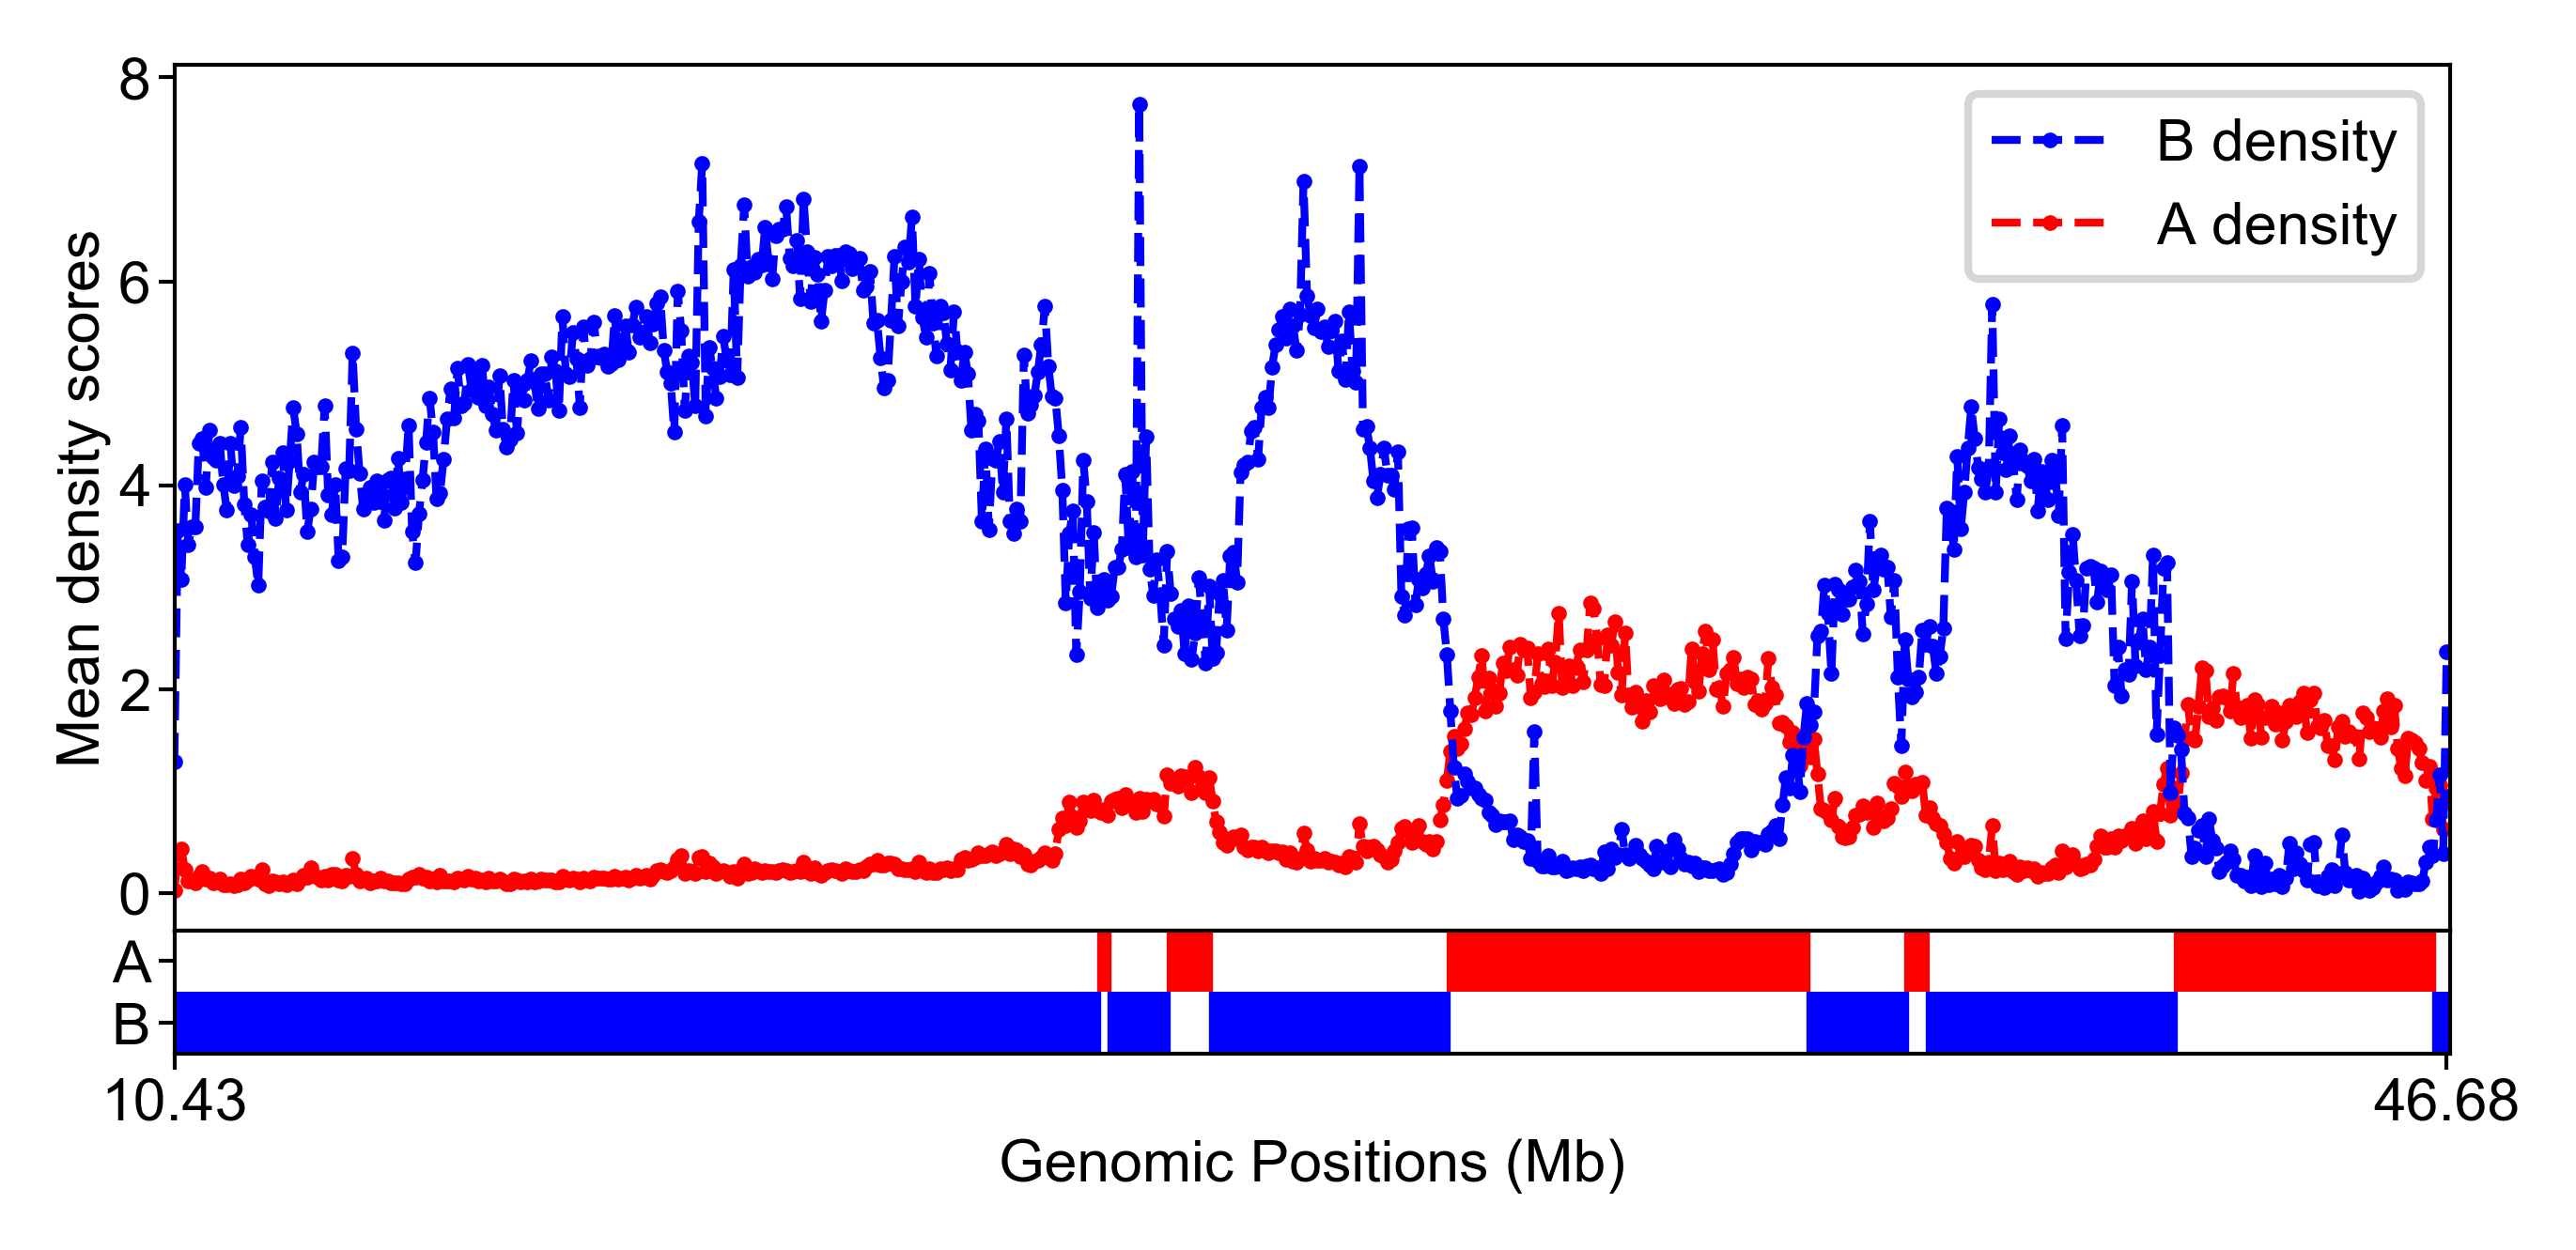

In [114]:
# Calculate mean A, B density
mean_A_scores = np.nanmedian([_s['A'] for _s in data_rep2['dna_density_scores']], axis=0)
mean_B_scores = np.nanmedian([_s['B'] for _s in data_rep2['dna_density_scores']], axis=0)

# Plot
fig = plt.figure(figsize=(_double_col_width, _single_col_width),dpi=600)
grid = plt.GridSpec(2, 1, height_ratios=[7,1], hspace=0., wspace=0.2)

main_ax = plt.subplot(grid[0], xticklabels=[])

main_ax.plot(mean_A_scores, 'r.--', label='A density', markersize=2, linewidth=1)
main_ax.plot(mean_B_scores, 'b.--', label='B density', markersize=2, linewidth=1)

# ticks
main_ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelbottom=False) # remove bottom ticklabels for ax1
main_ax.tick_params('x', length=0)
[i[1].set_linewidth(_ticklabel_width) for i in main_ax.spines.items()]
main_ax.set_ylabel(f"Mean density scores", fontsize=_font_size, labelpad=1)

handles, labels = main_ax.get_legend_handles_labels()
main_ax.legend(handles[::-1], labels[::-1], fontsize=_font_size, loc='upper right')
main_ax.set_xlim(0,len(mean_A_scores))

comp_ax = plt.subplot(grid[1], xticklabels=[], sharex=main_ax)
comp_ax.eventplot([data_rep2['AB_dict']['A'], data_rep2['AB_dict']['B']], lineoffsets=[0.5,-0.5],linelengths=1, linewidths=1, 
                   colors=np.array([[1, 0, 0],[0, 0, 1]]))
#comp_ax.imshow(comp_vector[np.newaxis,:], cmap='seismic', vmin=-1, vmax=1)
comp_ax.tick_params('both', labelsize=_font_size, 
                    width=_ticklabel_width, length=_ticklabel_size,
                    pad=1, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in comp_ax.spines.items()]

comp_ax.set_yticks([0.5,-0.5])
comp_ax.set_yticklabels(["A","B"])
comp_ax.set_ylim([-1,1])
_xticks = [0, len(mean_A_scores)-1]
comp_ax.set_xticks(_xticks)
comp_ax.set_xticklabels(mid_positions_Mb[_xticks])
comp_ax.set_xlabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=1)

plt.gcf().subplots_adjust(bottom=0.1, left=0.05)

plt.savefig(os.path.join(figure_folder, 'FigS2C_chr21_mean_AB_density_rep2.pdf'), transparent=True)

plt.show()

### 0.1.4 segregation scores

In [29]:
def randomize_AB_dict(AB_dict):
    all_regs = np.sort(np.concatenate(list(AB_dict.values())))
    AB_identities = np.zeros(len(all_regs))
    AB_identities[np.array([_i for _i,_r in enumerate(all_regs) 
                            if _r in AB_dict['A']])] = 1
    # randomize new start
    new_start = np.random.randint(0, len(all_regs))
    new_AB_identities = np.concatenate([AB_identities[new_start:], AB_identities[:new_start]])
    # recreate AB_dict
    new_AB_dict = {'A': np.sort(all_regs[np.where(new_AB_identities==1)[0]]),
                   'B': np.sort(all_regs[np.where(new_AB_identities==0)[0]]),}
    return new_AB_dict

# calculate dynamic fraction scores
from scipy.stats import scoreatpercentile

In [30]:
AB_identities_rep1 = np.ones(len(data_rep1['dna_hzxys'][0])) * np.nan
AB_identities_rep1[data_rep1['AB_dict']['A']] = 1
AB_identities_rep1[data_rep1['AB_dict']['B']] = 0

from tqdm import tqdm
# calculate re-thresholded fraction scores
A_fracs, B_fracs = [], []
A_ths, B_ths = [], []
cloud_th_per=67
for _sd in tqdm(data_rep1['dna_density_scores']):
    # define A,B threshold based on their own densities
    _A_th = scoreatpercentile(_sd['A'][data_rep1['AB_dict']['A']], 100-cloud_th_per)
    _B_th = scoreatpercentile(_sd['B'][data_rep1['AB_dict']['B']], 100-cloud_th_per)
    # calculate purity within A,B clouds
    A_fracs.append(np.nanmean(AB_identities_rep1[np.where(_sd['A'] >= _A_th)[0]]))
    B_fracs.append(1-np.nanmean(AB_identities_rep1[np.where(_sd['B'] >= _B_th)[0]]))
    # store AB thresholds for references
    A_ths.append(_A_th)
    B_ths.append(_B_th)
# calculate re-thresholded fraction scores
rand_A_fracs, rand_B_fracs = [], []

for _sd in tqdm(data_rep1['dna_density_scores']):
    # randomize AB dict
    _rand_AB_dict = randomize_AB_dict(data_rep1['AB_dict'])
    _rand_A_inds, _rand_B_inds = np.array(_rand_AB_dict['A']), np.array(_rand_AB_dict['B'])
    # generate randomized AB_identities_rep1 vector for purity calculation
    _rand_AB_identities_rep1 = np.ones(len(data_rep1['dna_hzxys'][0])) * np.nan
    _rand_AB_identities_rep1[_rand_AB_dict['A']] = 1
    _rand_AB_identities_rep1[_rand_AB_dict['B']] = 0
    # define A,B threshold based on their own densities
    _A_th = scoreatpercentile(_sd['A'][_rand_A_inds], 100-cloud_th_per)
    _B_th = scoreatpercentile(_sd['B'][_rand_B_inds], 100-cloud_th_per)
    # calculate purity within A,B clouds
    rand_A_fracs.append(np.nanmean(_rand_AB_identities_rep1[np.where(_sd['A'] >= _A_th)[0]]))
    rand_B_fracs.append(1-np.nanmean(_rand_AB_identities_rep1[np.where(_sd['B'] >= _B_th)[0]]))

# Save
data_rep1['segregation_scores'] = (np.array(A_fracs) + np.array(B_fracs)) / 2
data_rep1['randomized_segregation_scores'] = (np.array(rand_A_fracs) + np.array(rand_B_fracs)) / 2

  0%|                                                                                         | 0/7591 [00:00<?, ?it/s]E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
 15%|███████████▋                                                                | 1164/7591 [00:00<00:01, 5736.53it/s]E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
  0%|                                                                                         | 0/7591 [00:00<?, ?it/s]E:\Users\puzheng\anaconda3\lib\

In [31]:
AB_identities_rep2 = np.ones(len(data_rep2['dna_hzxys'][0])) * np.nan
AB_identities_rep2[data_rep2['AB_dict']['A']] = 1
AB_identities_rep2[data_rep2['AB_dict']['B']] = 0

from tqdm import tqdm
# calculate re-thresholded fraction scores
A_fracs, B_fracs = [], []
A_ths, B_ths = [], []
cloud_th_per=67
for _sd in tqdm(data_rep2['dna_density_scores']):
    # define A,B threshold based on their own densities
    _A_th = scoreatpercentile(_sd['A'][data_rep2['AB_dict']['A']], 100-cloud_th_per)
    _B_th = scoreatpercentile(_sd['B'][data_rep2['AB_dict']['B']], 100-cloud_th_per)
    # calculate purity within A,B clouds
    A_fracs.append(np.nanmean(AB_identities_rep2[np.where(_sd['A'] >= _A_th)[0]]))
    B_fracs.append(1-np.nanmean(AB_identities_rep2[np.where(_sd['B'] >= _B_th)[0]]))
    # store AB thresholds for references
    A_ths.append(_A_th)
    B_ths.append(_B_th)
# calculate re-thresholded fraction scores
rand_A_fracs, rand_B_fracs = [], []

for _sd in tqdm(data_rep2['dna_density_scores']):
    # randomize AB dict
    _rand_AB_dict = randomize_AB_dict(data_rep2['AB_dict'])
    _rand_A_inds, _rand_B_inds = np.array(_rand_AB_dict['A']), np.array(_rand_AB_dict['B'])
    # generate randomized AB_identities_rep2 vector for purity calculation
    _rand_AB_identities_rep2 = np.ones(len(data_rep2['dna_hzxys'][0])) * np.nan
    _rand_AB_identities_rep2[_rand_AB_dict['A']] = 1
    _rand_AB_identities_rep2[_rand_AB_dict['B']] = 0
    # define A,B threshold based on their own densities
    _A_th = scoreatpercentile(_sd['A'][_rand_A_inds], 100-cloud_th_per)
    _B_th = scoreatpercentile(_sd['B'][_rand_B_inds], 100-cloud_th_per)
    # calculate purity within A,B clouds
    rand_A_fracs.append(np.nanmean(_rand_AB_identities_rep2[np.where(_sd['A'] >= _A_th)[0]]))
    rand_B_fracs.append(1-np.nanmean(_rand_AB_identities_rep2[np.where(_sd['B'] >= _B_th)[0]]))

# Save
data_rep2['segregation_scores'] = (np.array(A_fracs) + np.array(B_fracs)) / 2
data_rep2['randomized_segregation_scores'] = (np.array(rand_A_fracs) + np.array(rand_B_fracs)) / 2

  0%|                                                                                         | 0/4558 [00:00<?, ?it/s]E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()
 12%|█████████▍                                                                   | 562/4558 [00:00<00:00, 5614.41it/s]E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
  0%|                                                                                         | 0/4558 [00:00<?, ?it/s]E:\Users\puzheng\anaconda3\lib\

## Fig 2C: segregation score histogram for Chr21

E:\Users\puzheng\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
E:\Users\puzheng\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


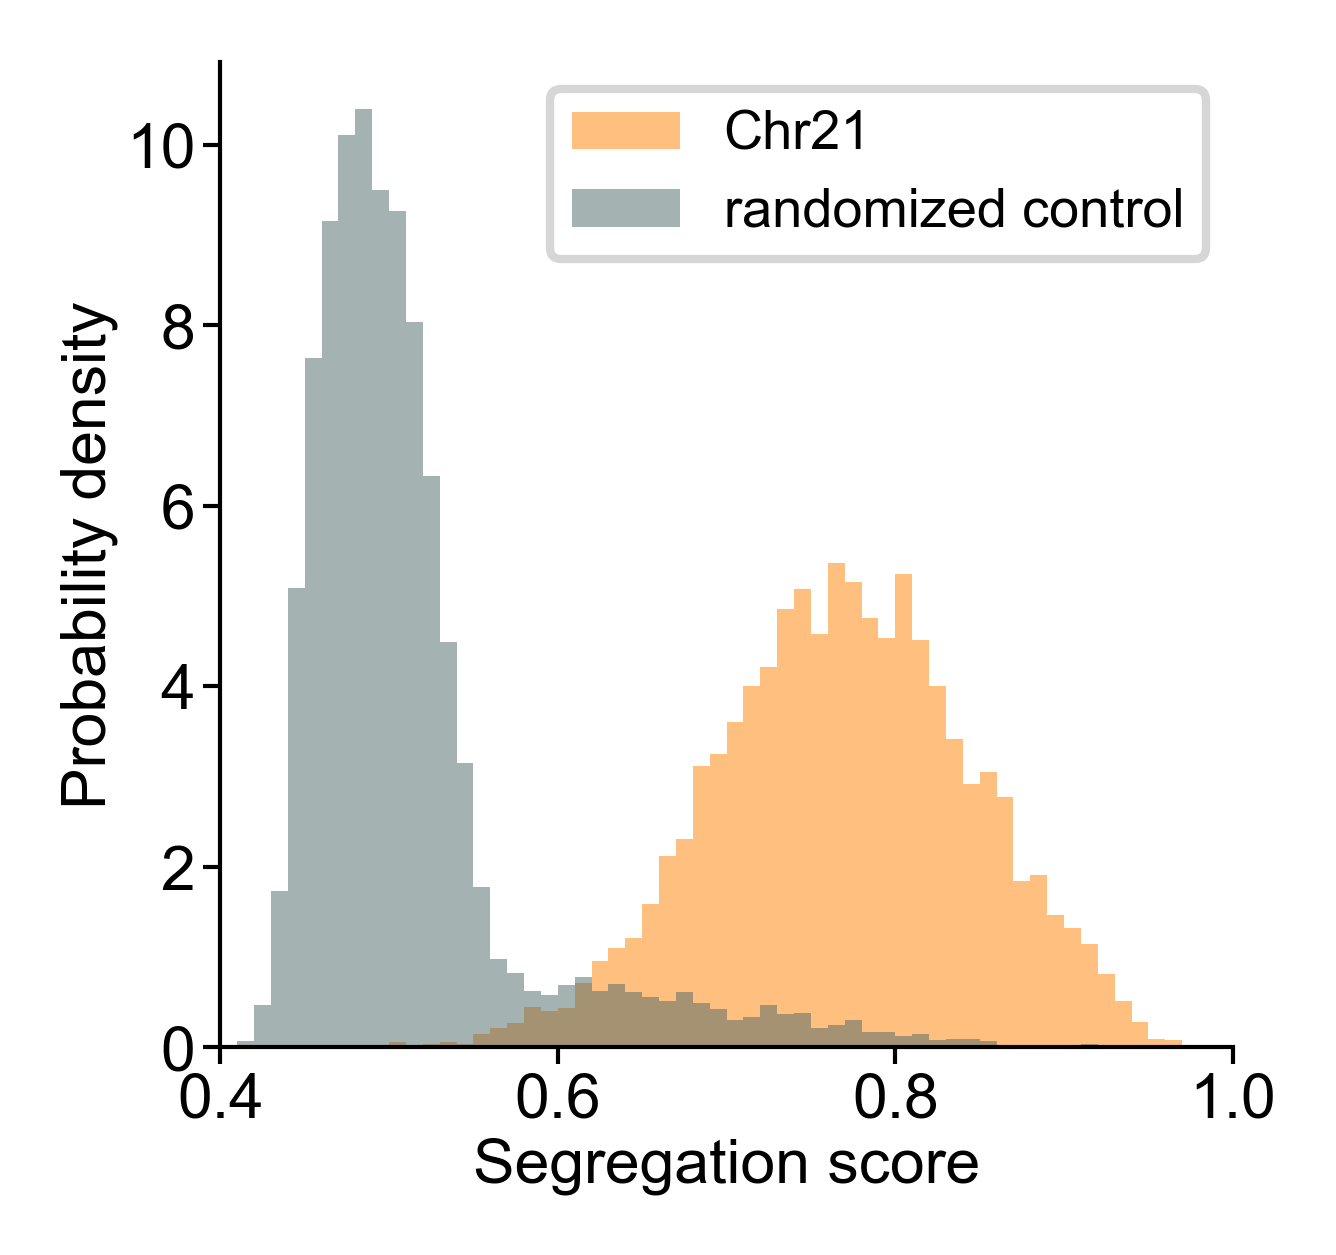

In [119]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)
ax.hist(data_rep1['segregation_scores'], 100, range=(0.,1), 
        density=True, alpha=0.5, 
        color=[1,0.5,0], label='Chr21')
ax.hist(data_rep1['randomized_segregation_scores'], 100, range=(0.,1), 
        density=True, alpha=0.5, 
        color=[0.3,0.4,0.4], label='randomized control')

ax.legend(fontsize=_font_size-1, loc='upper right')

ax.set_xlabel("Segregation score", fontsize=_font_size, labelpad=1)
ax.set_ylabel("Probability density", fontsize=_font_size, labelpad=1)

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True) # remove bottom ticklabels for a_ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0.4,1])

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.savefig(os.path.join(figure_folder, 'Fig2C_chr21_segregation_hist_rep1.pdf'), transparent=True)
plt.show()

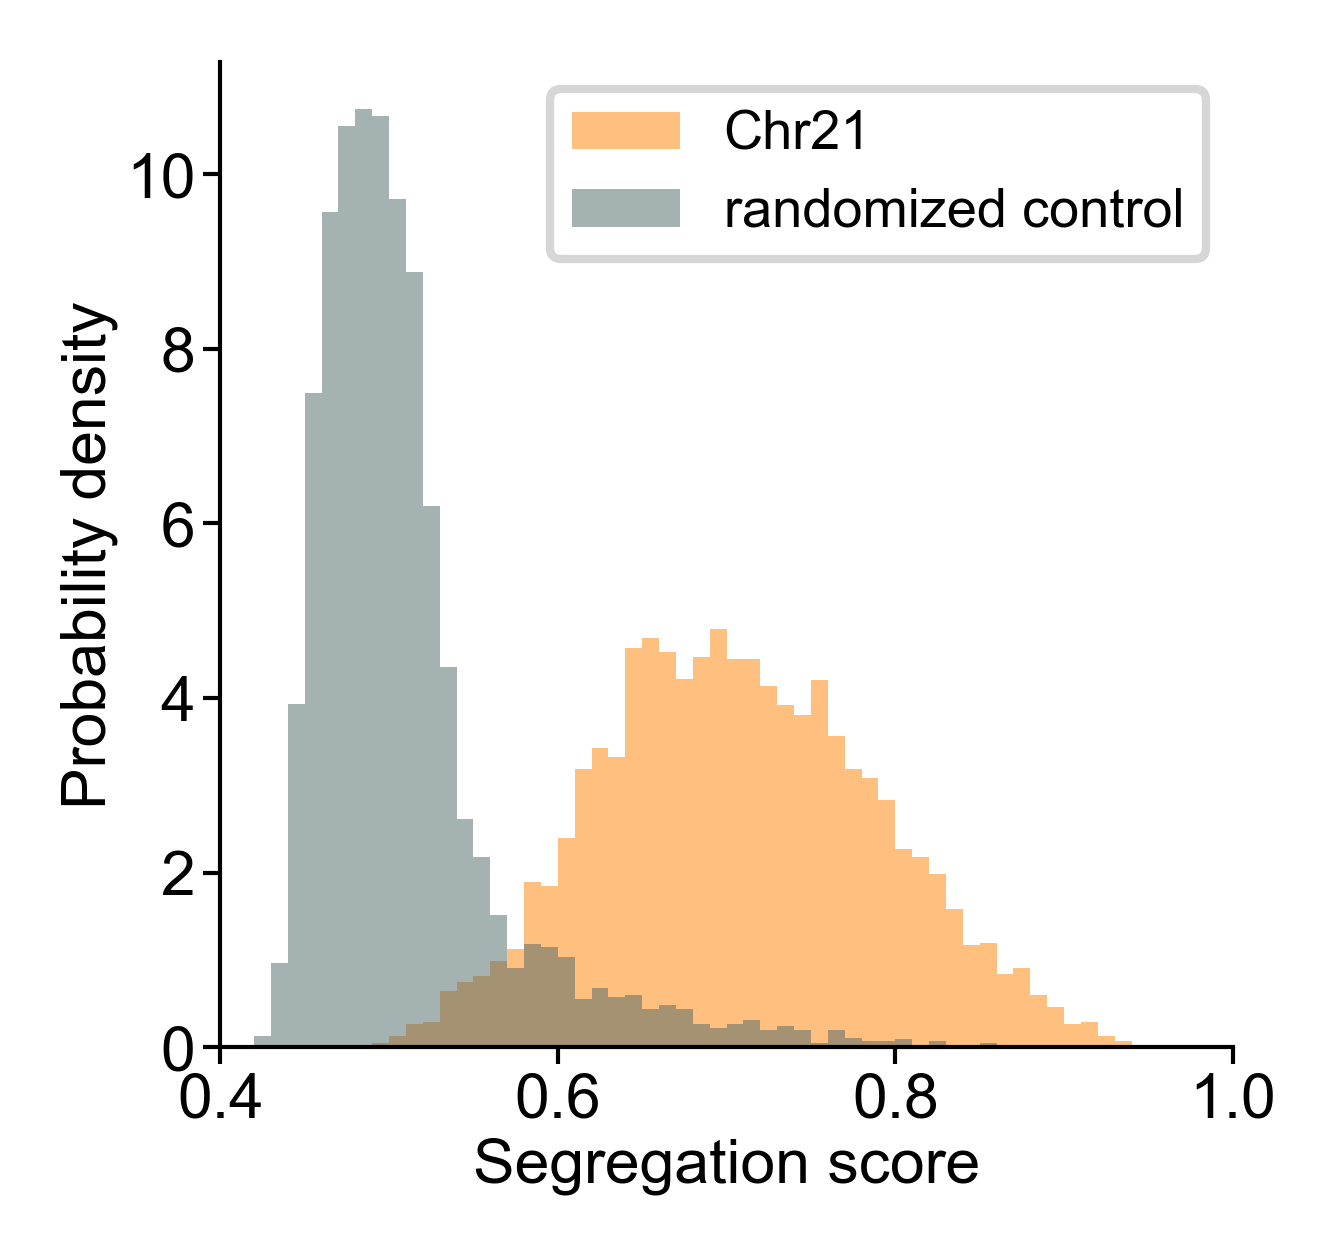

In [117]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)
ax.hist(data_rep2['segregation_scores'], 100, range=(0.,1), 
        density=True, alpha=0.5, 
        color=[1,0.5,0], label='Chr21')
ax.hist(data_rep2['randomized_segregation_scores'], 100, range=(0.,1), 
        density=True, alpha=0.5, 
        color=[0.3,0.4,0.4], label='randomized control')

ax.legend(fontsize=_font_size-1, loc='upper right')

ax.set_xlabel("Segregation score", fontsize=_font_size, labelpad=1)
ax.set_ylabel("Probability density", fontsize=_font_size, labelpad=1)

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True) # remove bottom ticklabels for a_ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0.4,1])

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.savefig(os.path.join(figure_folder, 'Fig2C_chr21_segregation_hist_rep2.pdf'), transparent=True)
plt.show()

## Figure 2H: A/B density ratio difference w/wo transcription

E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


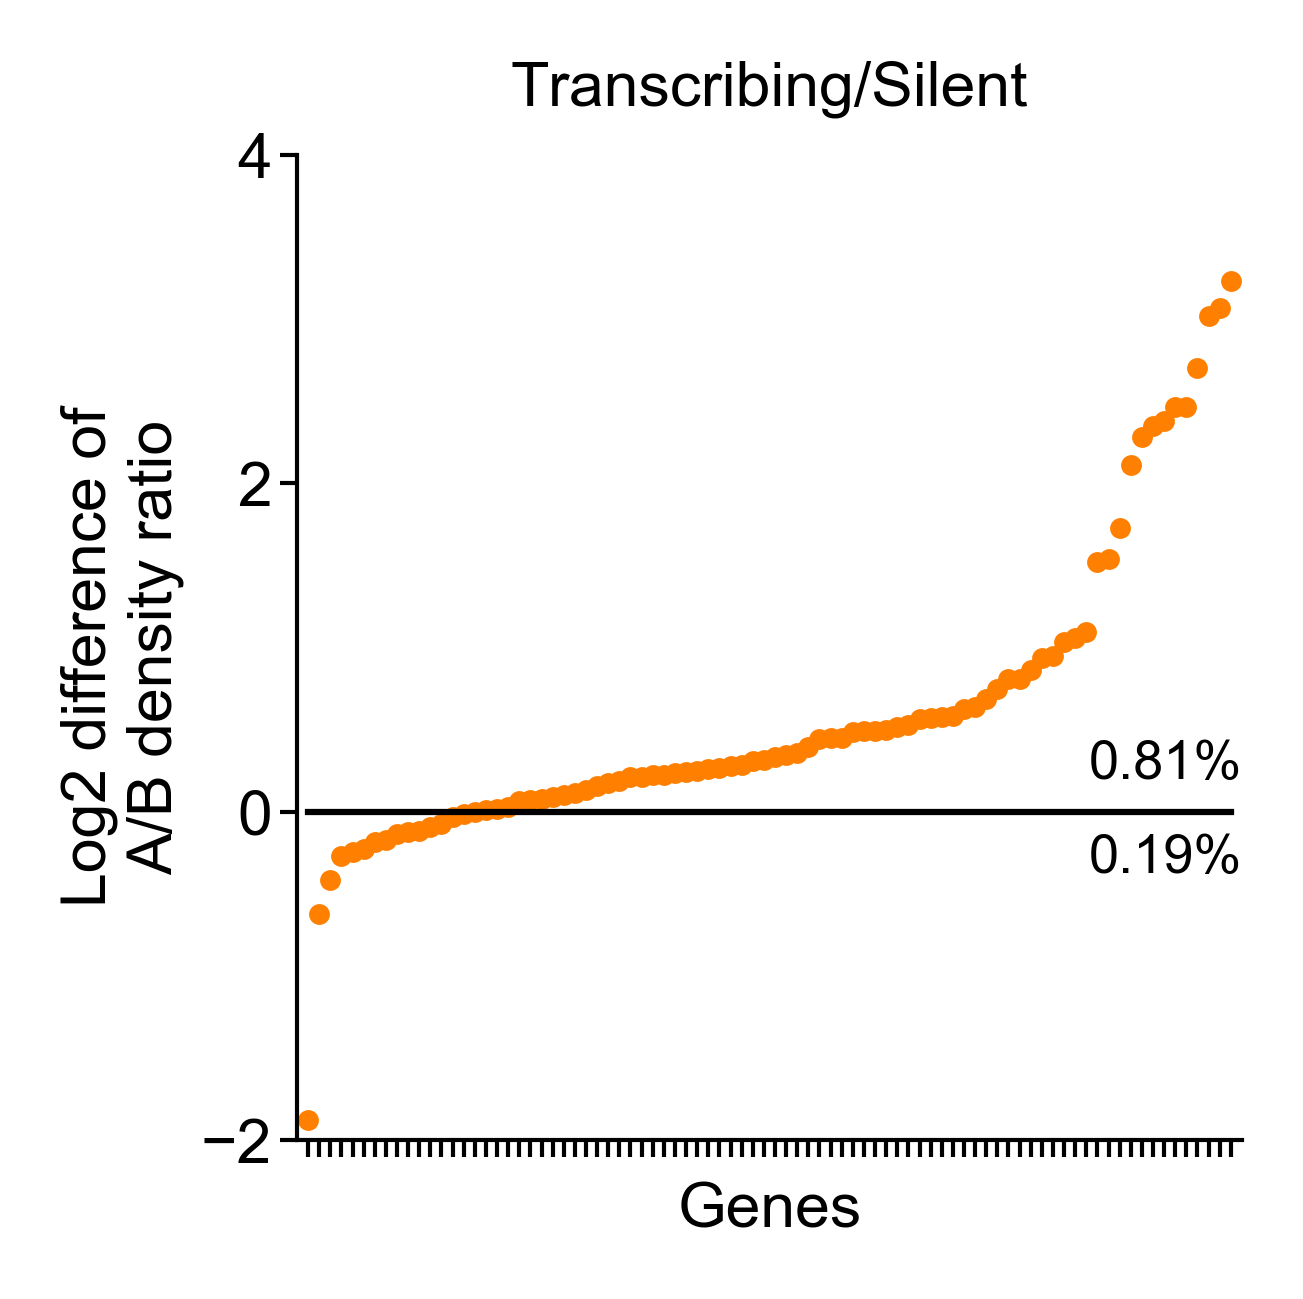

In [120]:
gene_density_dicts = data_rep1['gene_density_scores']
gene_A_scores = np.array([_gsd['A'] for _gsd in gene_density_dicts])
gene_B_scores = np.array([_gsd['B'] for _gsd in gene_density_dicts])

trans_pfs = np.array([np.isnan(_rna_pts).sum(1) == 0 for _rna_pts in data_rep1['rna_hzxys']])

on_gene_AB_ratio, off_gene_AB_ratio = [], []
on_gene_total_density = []
off_gene_total_density = []

for _gind in range(gene_A_scores.shape[1]):
    # extract AB and transcription
    _a_scores = gene_A_scores[:, _gind]
    _b_scores = gene_B_scores[:, _gind]
    _transcriptions = trans_pfs[:,_gind]
    # get AB ratio
    _log_ab_ratios = np.log(_a_scores)/np.log(2) - np.log(_b_scores)/np.log(2)
    _total_density =  _a_scores+_b_scores
    # append
    on_gene_AB_ratio.append(np.nanmedian(_log_ab_ratios[_transcriptions & (np.isinf(_log_ab_ratios)==False)]))
    off_gene_AB_ratio.append(np.nanmedian(_log_ab_ratios[~_transcriptions & (np.isinf(_log_ab_ratios)==False)]))
    on_gene_total_density.append(np.nanmedian(_total_density[_transcriptions & (np.isinf(_total_density)==False)]))
    off_gene_total_density.append(np.nanmedian(_total_density[~_transcriptions & (np.isinf(_total_density)==False)]))


# convert into arrays
on_gene_AB_ratio = np.array(on_gene_AB_ratio)
off_gene_AB_ratio = np.array(off_gene_AB_ratio)
on_gene_total_density = np.array(on_gene_total_density)
off_gene_total_density = np.array(off_gene_total_density)

gene_ratio_diff = on_gene_AB_ratio - off_gene_AB_ratio

fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)

ax.plot(np.sort(gene_ratio_diff), '.', color=[1,0.5,0], label='All genes', markersize=3)
ax.plot(np.zeros(len(gene_ratio_diff)), 'black', label='ref', linewidth=0.75)

ax.tick_params('both', labelsize=_font_size, width=_ticklabel_width, length=_ticklabel_size, pad=1) 
        
        # remove bottom ticklabels for ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xticks(np.arange(len(gene_ratio_diff)))
ax.set_yticks(np.arange(-6,6,2))
ax.set_xticklabels([])
ax.set_xlabel('Genes', fontsize=_font_size, labelpad=2)
ax.set_ylabel('Log2 difference of \nA/B density ratio', fontsize=_font_size, labelpad=2)
ax.set_xlim([-1, len(gene_ratio_diff)])
ax.set_ylim([-2,4])

#ax.legend(fontsize=_font_size, framealpha=1, loc='upper left')
ax.text(len(gene_ratio_diff), max(ax.get_ylim())/30, f'{np.mean(gene_ratio_diff>0):.2f}%', 
        fontsize=_font_size-1, verticalalignment='bottom', horizontalalignment='right',)
ax.text(len(gene_ratio_diff), -max(ax.get_ylim())/30, f'{np.mean(gene_ratio_diff<0):.2f}%', 
        fontsize=_font_size-1, verticalalignment='top', horizontalalignment='right',)

ax.set_title("Transcribing/Silent", fontsize=_font_size)
plt.gcf().subplots_adjust(left=0.2, bottom=0.15)

plt.savefig(os.path.join(figure_folder, 'Fig2H_diff_abratio_w-wo_transcribe_rep1.pdf'), transparent=True)

plt.show()

E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


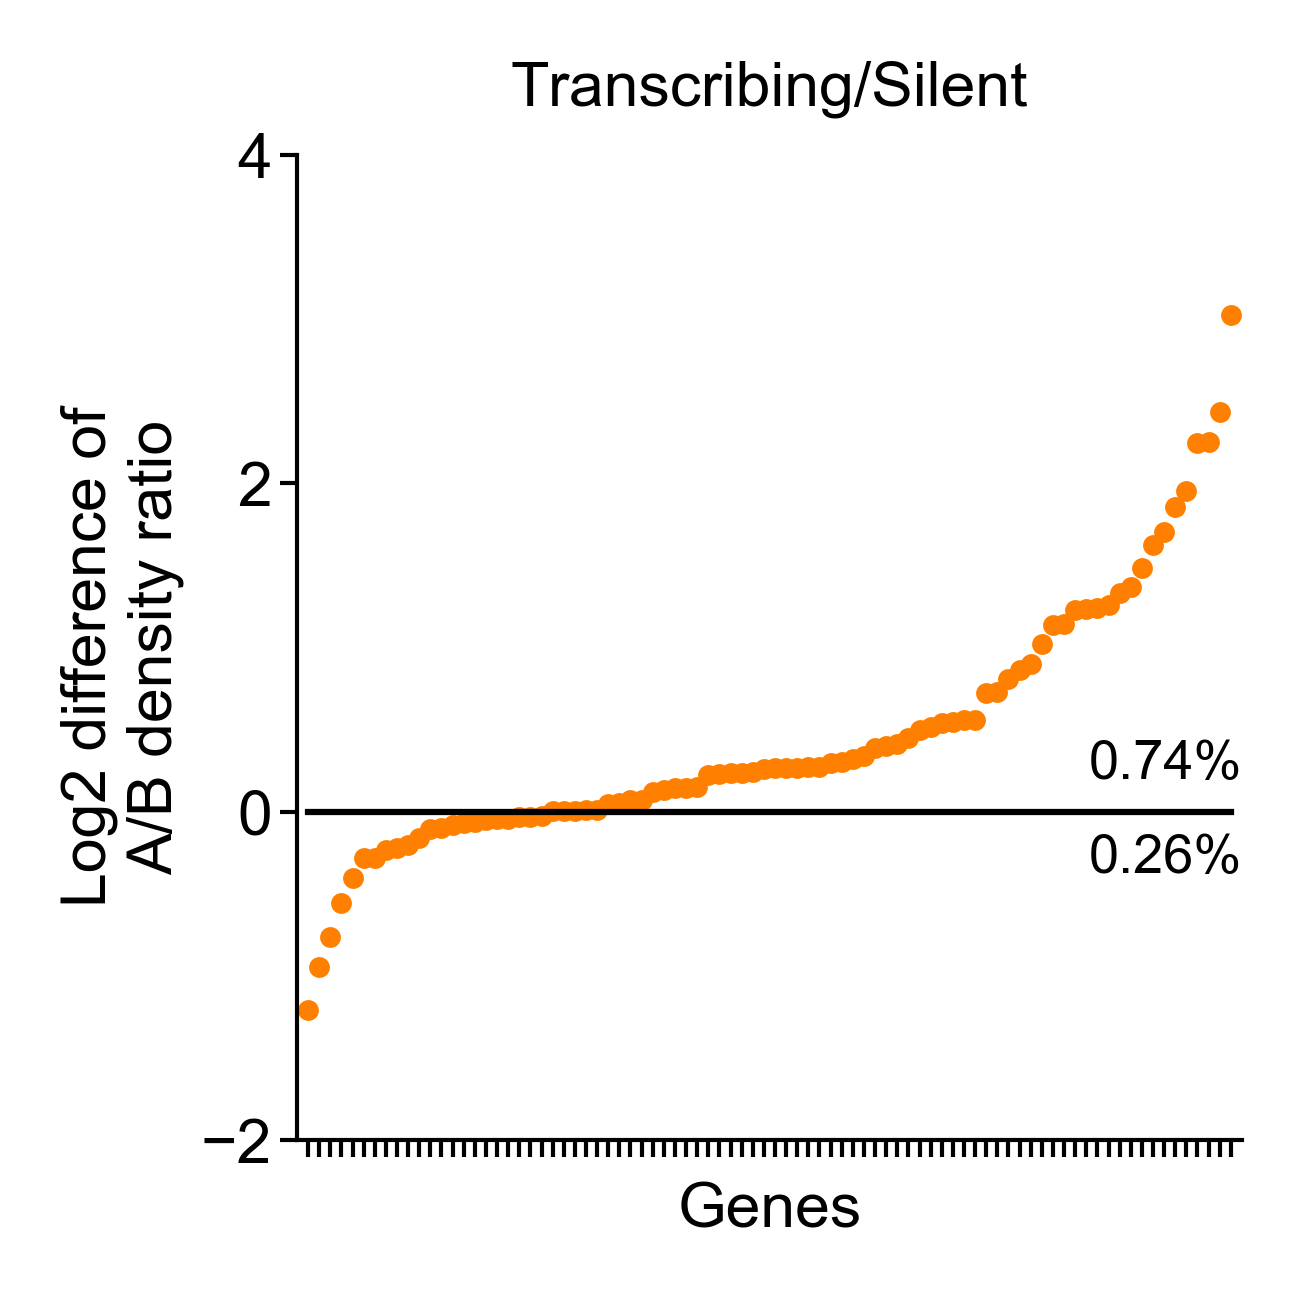

In [72]:
gene_density_dicts = data_rep2['gene_density_scores']
gene_A_scores = np.array([_gsd['A'] for _gsd in gene_density_dicts])
gene_B_scores = np.array([_gsd['B'] for _gsd in gene_density_dicts])

trans_pfs = np.array([np.isnan(_rna_pts).sum(1) == 0 for _rna_pts in data_rep2['rna_hzxys']])

on_gene_AB_ratio, off_gene_AB_ratio = [], []
on_gene_total_density = []
off_gene_total_density = []

for _gind in range(gene_A_scores.shape[1]):
    # extract AB and transcription
    _a_scores = gene_A_scores[:, _gind]
    _b_scores = gene_B_scores[:, _gind]
    _transcriptions = trans_pfs[:,_gind]
    # get AB ratio
    _log_ab_ratios = np.log(_a_scores)/np.log(2) - np.log(_b_scores)/np.log(2)
    _total_density =  _a_scores+_b_scores
    # append
    on_gene_AB_ratio.append(np.nanmedian(_log_ab_ratios[_transcriptions & (np.isinf(_log_ab_ratios)==False)]))
    off_gene_AB_ratio.append(np.nanmedian(_log_ab_ratios[~_transcriptions & (np.isinf(_log_ab_ratios)==False)]))
    on_gene_total_density.append(np.nanmedian(_total_density[_transcriptions & (np.isinf(_total_density)==False)]))
    off_gene_total_density.append(np.nanmedian(_total_density[~_transcriptions & (np.isinf(_total_density)==False)]))


# convert into arrays
on_gene_AB_ratio = np.array(on_gene_AB_ratio)
off_gene_AB_ratio = np.array(off_gene_AB_ratio)
on_gene_total_density = np.array(on_gene_total_density)
off_gene_total_density = np.array(off_gene_total_density)

gene_ratio_diff = on_gene_AB_ratio - off_gene_AB_ratio

fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)

ax.plot(np.sort(gene_ratio_diff), '.', color=[1,0.5,0], label='All genes', markersize=3)
ax.plot(np.zeros(len(gene_ratio_diff)), 'black', label='ref', linewidth=0.75)

ax.tick_params('both', labelsize=_font_size, width=_ticklabel_width, length=_ticklabel_size, pad=1) 
        
        # remove bottom ticklabels for ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xticks(np.arange(len(gene_ratio_diff)))
ax.set_yticks(np.arange(-6,6,2))
ax.set_xticklabels([])
ax.set_xlabel('Genes', fontsize=_font_size, labelpad=2)
ax.set_ylabel('Log2 difference of \nA/B density ratio', fontsize=_font_size, labelpad=2)
ax.set_xlim([-1, len(gene_ratio_diff)])
ax.set_ylim([-2,4])

#ax.legend(fontsize=_font_size, framealpha=1, loc='upper left')
ax.text(len(gene_ratio_diff), max(ax.get_ylim())/30, f'{np.mean(gene_ratio_diff>0):.2f}%', 
        fontsize=_font_size-1, verticalalignment='bottom', horizontalalignment='right',)
ax.text(len(gene_ratio_diff), -max(ax.get_ylim())/30, f'{np.mean(gene_ratio_diff<0):.2f}%', 
        fontsize=_font_size-1, verticalalignment='top', horizontalalignment='right',)

ax.set_title("Transcribing/Silent", fontsize=_font_size)
plt.gcf().subplots_adjust(left=0.2, bottom=0.15)

plt.savefig(os.path.join(figure_folder, 'Fig2H_diff_abratio_w-wo_transcribe_rep2.pdf'), transparent=True)

plt.show()

## Figure 2I: firing rate difference with high/low A/B density ratio

E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in true_divide
  if sys.path[0] == '':


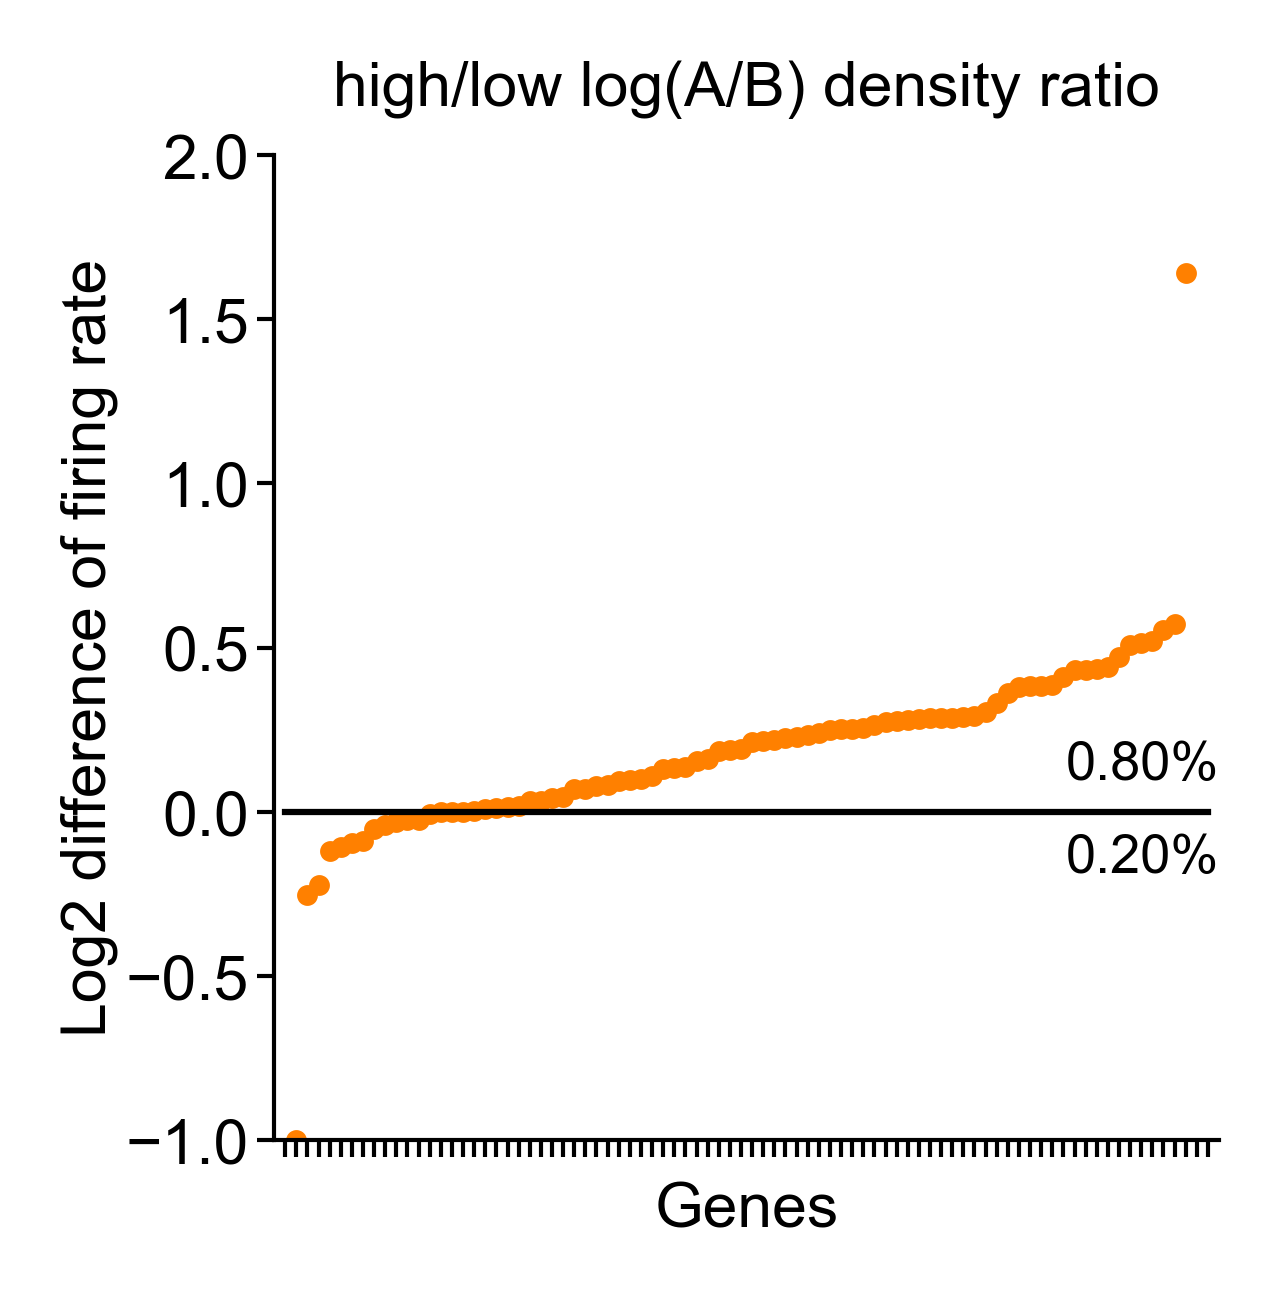

In [121]:
gene_density_dicts = data_rep1['gene_density_scores']
gene_A_scores = np.array([_gsd['A'] for _gsd in gene_density_dicts])
gene_B_scores = np.array([_gsd['B'] for _gsd in gene_density_dicts])

trans_pfs = np.array([np.isnan(_rna_pts).sum(1) == 0 for _rna_pts in data_rep1['rna_hzxys']])

abratio_ratio = []
for _gid in np.arange(trans_pfs.shape[1]):
    # extract info
    _ga = gene_A_scores[:,_gid]
    _gb = gene_B_scores[:,_gid]
    _gratio = np.log(_ga / _gb) 
    
    # sel_inds
    _inds = np.argsort(_gratio)
    _sel_v = np.where((np.isnan(_gratio)==False) * (np.isinf(_gratio)==False))[0]
    _sel_inds = np.array([_i for _i in _inds if _i in _sel_v], dtype=np.int)
    
    _li = _sel_inds[:int(len(_sel_inds)/4)]
    _hi = _sel_inds[-int(len(_sel_inds)/4):]
    #print(len(_sel_inds), np.mean(_gratio[_li]), np.mean(_gratio[_hi]))
    _lfr = np.nanmean(trans_pfs[_li, _gid])
    _hfr = np.nanmean(trans_pfs[_hi, _gid])
    abratio_ratio.append(_hfr / _lfr)

abratio_fr_ratio = np.log(np.array(abratio_ratio)) / np.log(2)

fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)

#ax.plot(np.arange(len(sel_A_gene_inds)), 
#        np.sort(np.log(abratio_ratio[sel_A_gene_inds])), 
#        'r.', label='A genes', markersize=3)
#ax.plot(np.arange(len(sel_A_gene_inds),len(sel_A_gene_inds)+len(sel_B_gene_inds)), 
#         np.sort(np.log(abratio_ratio[sel_B_gene_inds])), 
#        'b.', label='B genes', markersize=3)


ax.plot(np.sort(abratio_fr_ratio), 
        '.', color=[1,0.5,0], label='All genes', markersize=3)
ax.plot(np.zeros(len(abratio_fr_ratio)), 
        'black', label='reference', linewidth=0.75)

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1) # remove bottom ticklabels for ax1
ax.set_xticks(np.arange(len(abratio_fr_ratio)))
ax.set_xticklabels([])
ax.set_ylabel('Log odds ratio', fontsize=_font_size, labelpad=1)
ax.set_xlim([-1, len(abratio_fr_ratio)])
ax.set_ylim([-1,2])

[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel('Genes', fontsize=_font_size, labelpad=2)
ax.set_ylabel('Log2 difference of firing rate', fontsize=_font_size, labelpad=1)
ax.set_title(f"high/low log(A/B) density ratio", 
             fontsize=_font_size)

#ax.legend(fontsize=_font_size, framealpha=1, loc='upper left')

ax.text(len(abratio_fr_ratio), max(ax.get_ylim())/30, f'{np.mean(abratio_fr_ratio>0):.2f}%', 
        fontsize=_font_size-1, verticalalignment='bottom', horizontalalignment='right',)
ax.text(len(abratio_fr_ratio), -max(ax.get_ylim())/30, f'{np.mean(abratio_fr_ratio<=0):.2f}%', 
        fontsize=_font_size-1, verticalalignment='top', horizontalalignment='right',)

plt.gcf().subplots_adjust(left=0.2, bottom=0.15)

plt.savefig(os.path.join(figure_folder, f"Fig2I_firing-rate_diff_w_high-low_abratio_rep1.pdf"), transparent=True)

plt.show()

E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


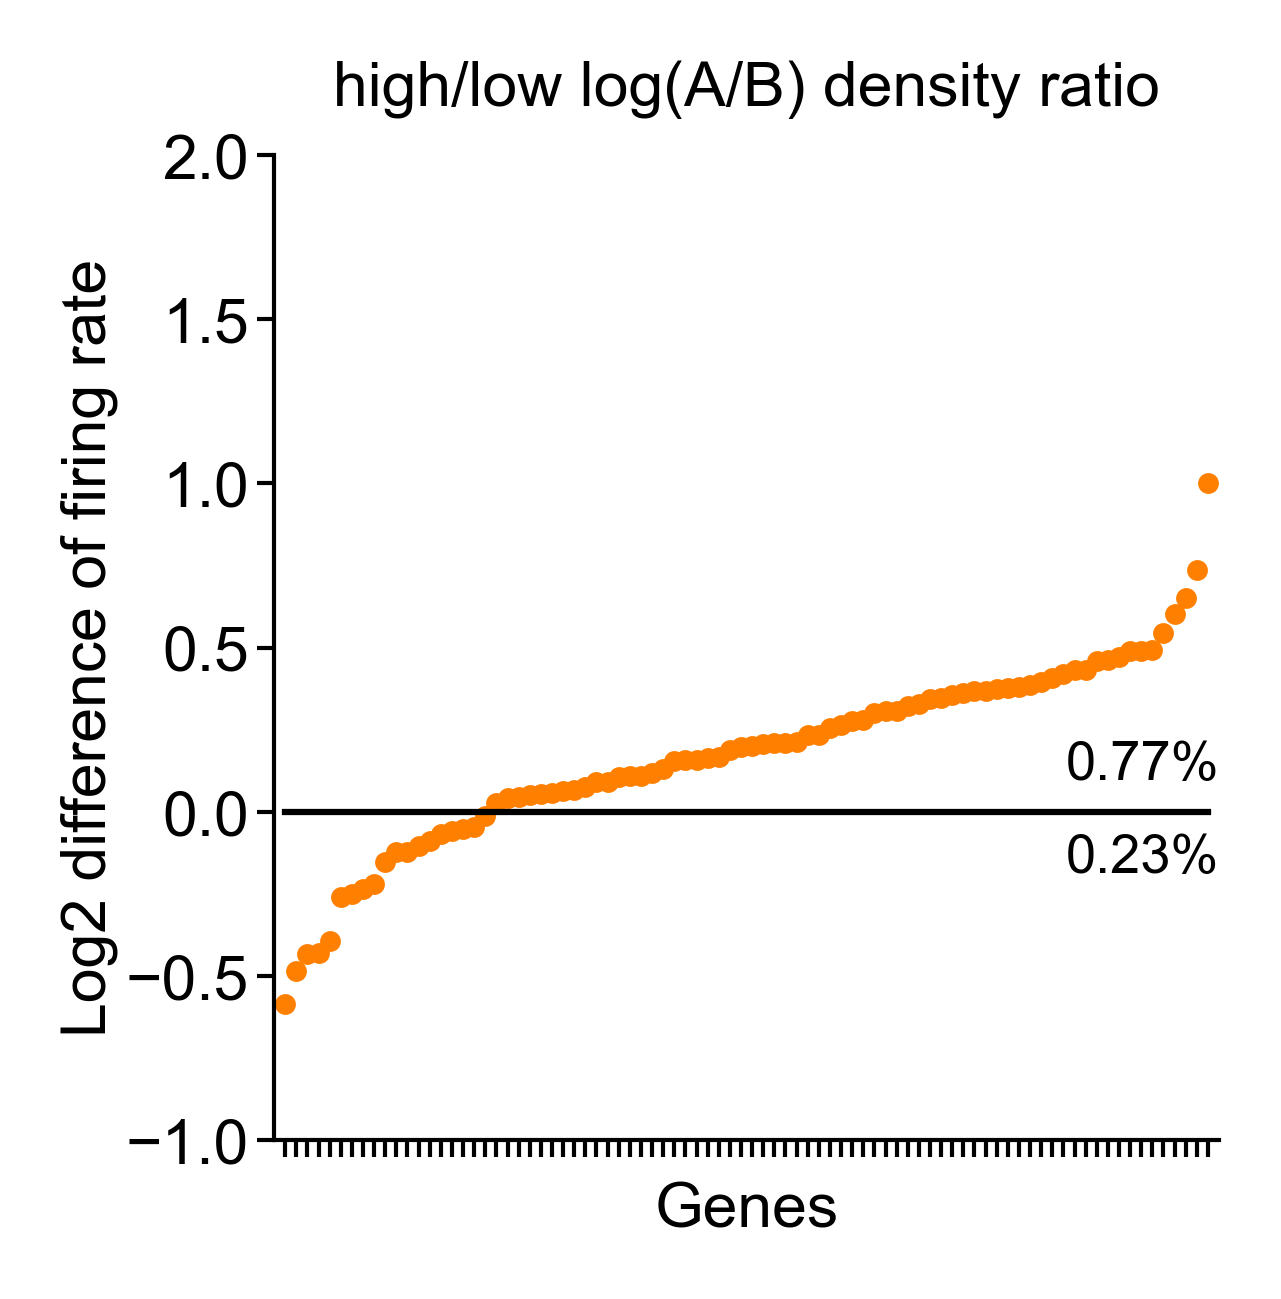

In [79]:
gene_density_dicts = data_rep2['gene_density_scores']
gene_A_scores = np.array([_gsd['A'] for _gsd in gene_density_dicts])
gene_B_scores = np.array([_gsd['B'] for _gsd in gene_density_dicts])

trans_pfs = np.array([np.isnan(_rna_pts).sum(1) == 0 for _rna_pts in data_rep2['rna_hzxys']])

abratio_ratio = []
for _gid in np.arange(trans_pfs.shape[1]):
    # extract info
    _ga = gene_A_scores[:,_gid]
    _gb = gene_B_scores[:,_gid]
    _gratio = np.log(_ga / _gb) 
    
    # sel_inds
    _inds = np.argsort(_gratio)
    _sel_v = np.where((np.isnan(_gratio)==False) * (np.isinf(_gratio)==False))[0]
    _sel_inds = np.array([_i for _i in _inds if _i in _sel_v], dtype=np.int)
    
    _li = _sel_inds[:int(len(_sel_inds)/4)]
    _hi = _sel_inds[-int(len(_sel_inds)/4):]
    #print(len(_sel_inds), np.mean(_gratio[_li]), np.mean(_gratio[_hi]))
    _lfr = np.nanmean(trans_pfs[_li, _gid])
    _hfr = np.nanmean(trans_pfs[_hi, _gid])
    abratio_ratio.append(_hfr / _lfr)

abratio_fr_ratio = np.log(np.array(abratio_ratio)) / np.log(2)

fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)

#ax.plot(np.arange(len(sel_A_gene_inds)), 
#        np.sort(np.log(abratio_ratio[sel_A_gene_inds])), 
#        'r.', label='A genes', markersize=3)
#ax.plot(np.arange(len(sel_A_gene_inds),len(sel_A_gene_inds)+len(sel_B_gene_inds)), 
#         np.sort(np.log(abratio_ratio[sel_B_gene_inds])), 
#        'b.', label='B genes', markersize=3)


ax.plot(np.sort(abratio_fr_ratio), 
        '.', color=[1,0.5,0], label='All genes', markersize=3)
ax.plot(np.zeros(len(abratio_fr_ratio)), 
        'black', label='reference', linewidth=0.75)

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1) # remove bottom ticklabels for ax1
ax.set_xticks(np.arange(len(abratio_fr_ratio)))
ax.set_xticklabels([])
ax.set_ylabel('Log odds ratio', fontsize=_font_size, labelpad=1)
ax.set_xlim([-1, len(abratio_fr_ratio)])
ax.set_ylim([-1,2])

[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel('Genes', fontsize=_font_size, labelpad=2)
ax.set_ylabel('Log2 difference of firing rate', fontsize=_font_size, labelpad=1)
ax.set_title(f"high/low log(A/B) density ratio", 
             fontsize=_font_size)

#ax.legend(fontsize=_font_size, framealpha=1, loc='upper left')

ax.text(len(abratio_fr_ratio), max(ax.get_ylim())/30, f'{np.mean(abratio_fr_ratio>0):.2f}%', 
        fontsize=_font_size-1, verticalalignment='bottom', horizontalalignment='right',)
ax.text(len(abratio_fr_ratio), -max(ax.get_ylim())/30, f'{np.mean(abratio_fr_ratio<=0):.2f}%', 
        fontsize=_font_size-1, verticalalignment='top', horizontalalignment='right',)

plt.gcf().subplots_adjust(left=0.2, bottom=0.15)

plt.savefig(os.path.join(figure_folder, f"Fig2I_firing-rate_diff_w_high-low_abratio_rep2.pdf"), transparent=True)

plt.show()